In [1]:
import torch
import os
import json
import sys
from torch.nn import CosineSimilarity
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, LlamaTokenizer
from functools import partial
from baukit import TraceDict
from einops import rearrange, einsum
from collections import defaultdict
import matplotlib.pyplot as plt
# from plotly_utils import imshow, scatter
from tqdm import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader
import math
import seaborn as sns
from peft import PeftModel
import pickle

import pysvelte
sys.path.append('../')
import analysis_utils
from data.data_utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(10)

%load_ext autoreload
%autoreload 2

/home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Model Loading...")
# path = "/data/nikhil_prakash/llama_weights/7B/"
# path = "AlekseyKorshuk/vicuna-7b"
# path = "/home/local_nikhil/Projects/llama_weights/7B"
# tokenizer = LlamaTokenizer.from_pretrained(path)
# model = AutoModelForCausalLM.from_pretrained(path).to(device)

base_model = "decapoda-research/llama-7b-hf"
lora_weights = "tiedong/goat-lora-7b"

tokenizer = LlamaTokenizer.from_pretrained(
    "hf-internal-testing/llama-tokenizer", padding_side="right"
)

model = LlamaForCausalLM.from_pretrained(
    base_model,
    load_in_8bit=False,
    torch_dtype=torch.float32,
    device_map="auto",
)
model = PeftModel.from_pretrained(
    model,
    lora_weights,
    torch_dtype=torch.float32,
    device_map={'': 0},
)

tokenizer.pad_token_id = tokenizer.eos_token_id

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Model Loading...


Loading checkpoint shards: 100%|██████████| 33/33 [00:12<00:00,  2.69it/s]


## Evaluating Models

In [3]:
data_file = "../data/dataset.jsonl"
object_file = "../data/objects.jsonl"
batch_size = 50

In [4]:
raw_data = entity_tracking_example_sampler(
    tokenizer=tokenizer,
    num_samples=500,
    data_file=data_file,
    architecture="LlamaForCausalLM",
)

dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
        "labels": raw_data[2],
    }
).with_format("torch")

print(f"Length of dataset: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=batch_size)

Length of dataset: 500


In [5]:
idx = 0
print(
    f"Prompt: {tokenizer.decode(dataset[idx]['input_ids'][:dataset[idx]['last_token_indices']+1])}"
)
print(f"Answer: {tokenizer.decode(dataset[idx]['labels'])}")

Prompt: <s>The document is in Box X, the pot is in Box T, the magnet is in Box A, the game is in Box E, the bill is in Box M, the cross is in Box K, the map is in Box D. Box X contains the
Answer: document


In [6]:
total_count = 0
correct_count = 0
model.eval()
errors = defaultdict(int)
with torch.no_grad():
    for _, output in tqdm(enumerate(tqdm(dataloader))):
        for k, v in output.items():
            if v is not None and isinstance(v, torch.Tensor):
                output[k] = v.to(model.device)

        outputs = model(input_ids=output["input_ids"])

        for bi in range(output["labels"].size(0)):
            label = output["labels"][bi]
            pred = torch.argmax(outputs.logits[bi][output["last_token_indices"][bi]])
            box_label = output["input_ids"][bi][output["last_token_indices"][bi] - 2]
            prev_box_label_pos = (
                output["input_ids"][bi].eq(box_label).nonzero()[:, 0][0].item()
            )
            prev_box_label_index = prev_box_label_pos // 8 + 1

            if label == pred:
                correct_count += 1
            else:
                errors[prev_box_label_index] += 1
                # print(prev_box_label_pos, prev_box_label_index)
                # print(f"Label: {tokenizer.decode(label)}, Prediction: {tokenizer.decode(pred)}")
            total_count += 1

del outputs
torch.cuda.empty_cache()

current_acc = round(correct_count / total_count, 2)
print(f"Task accuracy: {current_acc}")

 20%|██        | 2/10 [00:04<00:17,  2.23s/it]

100%|██████████| 10/10 [00:21<00:00,  2.17s/it]
10it [00:21,  2.17s/it]


Task accuracy: 0.82


## Evaluation Metrics

### Faithfulness

In [6]:
data_file = "../data/dataset.jsonl"
batch_size = 50

In [7]:
raw_data = get_data_for_mean_ablation(
    tokenizer=tokenizer,
    num_samples=3500,
    data_file=data_file,
    num_boxes=7,
)

ablate_dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
    }
).with_format("torch")

print(f"Length of dataset: {len(ablate_dataset)}")

ablate_dataloader = DataLoader(ablate_dataset, batch_size=batch_size)

Length of dataset: 500


In [8]:
idx = 8
print(
    f"Prompt: {tokenizer.decode(ablate_dataset[idx]['input_ids'][:ablate_dataset[idx]['last_token_indices']+1])}"
)

Prompt: <s>The magnet is in Box O, the bell is in Box M, the leaf is in Box W, the cup is in Box G, the ice is in Box J, the milk is in Box Z, the wire is in Box H. Box P contains the


In [9]:
if model.config.architectures[0] == "LlamaForCausalLM":
    modules = [f"model.layers.{layer}.self_attn.o_proj" for layer in range(32)]
else:
    modules = [
        f"base_model.model.model.layers.{layer}.self_attn.o_proj" for layer in range(32)
    ]

mean_activations = {}
with torch.no_grad():
    for _, inp in enumerate(tqdm(ablate_dataloader)):
        for k, v in inp.items():
            if v is not None and isinstance(v, torch.Tensor):
                inp[k] = v.to(model.device)

        with TraceDict(model, modules, retain_input=True) as cache:
            _ = model(inp["input_ids"])

        for layer in modules:
            if "o_proj" in layer:
                if layer in mean_activations:
                    mean_activations[layer] += torch.sum(cache[layer].input, dim=0)
                else:
                    mean_activations[layer] = torch.sum(cache[layer].input, dim=0)

        del cache
        torch.cuda.empty_cache()

    for layer in modules:
        mean_activations[layer] /= len(ablate_dataloader.dataset)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


In [10]:
def mean_ablate(
    inputs=None, output=None, layer=None, circuit_components=None, mean_activations=None, input_tokens=None
):
    if isinstance(inputs, tuple):
        inputs = inputs[0]

    inputs = rearrange(
        inputs,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    mean_act = rearrange(
        mean_activations[layer],
        "seq_len (n_heads d_head) -> seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    last_pos = inputs.size(1) - 1
    for bi in range(inputs.size(0)):
        try:
            prev_query_box_pos = analysis_utils.compute_prev_query_box_pos(
                input_tokens[bi], input_tokens[bi].size(0) - 1
            )
        except:
            print(tokenizer.decode(input_tokens[bi]))
        for token_pos in range(inputs.size(1)):
            if (
                token_pos != prev_query_box_pos
                and token_pos != last_pos - 2
                and token_pos != last_pos
            ):
                inputs[bi, token_pos, :] = mean_act[token_pos, :]
            
            elif token_pos == prev_query_box_pos:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[-1][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[token_pos, head_idx]
            
            elif token_pos == last_pos - 2:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[2][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[token_pos, head_idx]
            
            elif token_pos == last_pos:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[0][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[token_pos, head_idx]

    inputs = rearrange(
        inputs,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )
    w_o = model.state_dict()[f"{layer}.weight"]
    output = einsum(
        inputs,
        w_o,
        "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model",
    )

    return output

In [11]:
def eval(model, dataloader, modules, circuit_components, mean_activations):
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, inp in enumerate(tqdm(dataloader)):
            for k, v in inp.items():
                if v is not None and isinstance(v, torch.Tensor):
                    inp[k] = v.to(model.device)

            with TraceDict(
                model,
                modules,
                retain_input=True,
                edit_output=partial(
                    mean_ablate,
                    circuit_components=circuit_components,
                    mean_activations=mean_activations,
                    input_tokens=inp["input_ids"],
                ),
            ) as _:
                outputs = model(inp["input_ids"])

            for bi in range(inp["labels"].size(0)):
                label = inp["labels"][bi]
                pred = torch.argmax(
                    outputs.logits[bi][inp["last_token_indices"][bi]]
                )

                if label == pred:
                    correct_count += 1
                total_count += 1

            del outputs
            torch.cuda.empty_cache()

    current_acc = round(correct_count / total_count, 2)
    print(f"Task accuracy: {current_acc}")
    return current_acc

In [15]:
# eval(model, dataloader, modules, circuit_components, mean_activations)


## Greedy Approach - Computing Pair Drop Values

In [13]:
n_value_fetcher = 62
n_pos_trans = 15
n_pos_detect = 30
n_struct_read = 5
root_path = "../path_patching/results/"

### heads_at_prev_box_pos

In [13]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

greedy_res = defaultdict(lambda: defaultdict(float))

path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads, _ = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads, _ = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token, _ = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos, _ = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx_1, head_1 in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer_1 = f"model.layers.{layer_idx_1}.self_attn.o_proj"
    else:
        layer_1 = f"base_model.model.model.layers.{layer_idx_1}.self_attn.o_proj"

    circuit_components[-1][layer_1].remove(head_1)
    print("head 1:", layer_1, head_1)

    for layer_idx_2, head_2 in heads_at_prev_box_pos:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer_2 = f"model.layers.{layer_idx_2}.self_attn.o_proj"
        else:
            layer_2 = f"base_model.model.model.layers.{layer_idx_2}.self_attn.o_proj"
        if greedy_res[(layer_2, head_2)][(layer_1, head_1)] > 0.0:
            continue
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[-1][layer_2].remove(head_2)
        print("head 2:", layer_2, head_2)
        greedy_res[(layer_1, head_1)][(layer_2, head_2)] = eval(
            model, dataloader, modules, circuit_components, mean_activations
        )
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[-1][layer_2].append(head_2)

    circuit_components[-1][layer_1].append(head_1)

50 15 30 5
head 1: model.layers.8.self_attn.o_proj 21
head 2: model.layers.8.self_attn.o_proj 21


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.47
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.45
head 2: model.layers.11.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.46
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.46
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.45
head 1: model.layers.12.self_attn.o_proj 23
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.61
head 2: model.layers.11.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.6
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 1: model.layers.11.self_attn.o_proj 9
head 2: model.layers.11.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.61
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.6
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.6
head 1: model.layers.8.self_attn.o_proj 12
head 2: model.layers.8.self_attn.o_proj 12


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.6
head 1: model.layers.11.self_attn.o_proj 23
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]

Task accuracy: 0.61


In [15]:
res = defaultdict(lambda: defaultdict(float))
for k in greedy_res:
    for k_2 in greedy_res[k]:
        if greedy_res[k][k_2] > 0.0:
            res[str(k)][str(k_2)] = greedy_res[k][k_2]
            res[str(k_2)][str(k)] = greedy_res[k][k_2]

In [16]:
with open("../path_patching/results/minimality/llama_heads_at_prev_box_pos.json", "w") as file:
    json.dump(res, file)

### head_at_query_box_token

In [14]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

greedy_res = defaultdict(lambda: defaultdict(float))

path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads, _ = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads, _ = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token, _ = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos, _ = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx_1, head_1 in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer_1 = f"model.layers.{layer_idx_1}.self_attn.o_proj"
    else:
        layer_1 = f"base_model.model.model.layers.{layer_idx_1}.self_attn.o_proj"

    circuit_components[2][layer_1].remove(head_1)
    print("head 1:", layer_1, head_1)

    for layer_idx_2, head_2 in head_at_query_box_token:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer_2 = f"model.layers.{layer_idx_2}.self_attn.o_proj"
        else:
            layer_2 = f"base_model.model.model.layers.{layer_idx_2}.self_attn.o_proj"

        if greedy_res[(layer_2, head_2)][(layer_1, head_1)] > 0.0:
            continue
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[2][layer_2].remove(head_2)

        print("head 2:", layer_2, head_2)
        greedy_res[(layer_1, head_1)][(layer_2, head_2)] = eval(
            model, dataloader, modules, circuit_components, mean_activations
        )
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[2][layer_2].append(head_2)

    circuit_components[2][layer_1].append(head_1)

50 15 30 5
head 1: model.layers.10.self_attn.o_proj 3
head 2: model.layers.10.self_attn.o_proj 3


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Task accuracy: 0.52
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Task accuracy: 0.47
head 2: model.layers.9.self_attn.o_proj 2


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.46
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.46
head 2: model.layers.1.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.47
head 2: model.layers.9.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.48
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.38
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.42
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.48
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.51
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.5
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.5
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.42
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.52
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.5
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.52
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.5
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.52
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Task accuracy: 0.5
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.5
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.52
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.5
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.5
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.49
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.52
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.52
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.47
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.44
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.51
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.52
head 1: model.layers.13.self_attn.o_proj 14
head 2: model.layers.13.self_attn.o_proj 14


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 2


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.56
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.5
head 2: model.layers.1.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.5
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.57
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.52
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.57
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.57
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.53
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.57
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.57
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.58
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.57
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.57
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.55
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.57
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.56
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.57
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.79s/it]


Task accuracy: 0.57
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.54
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.52
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.57
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.57
head 1: model.layers.9.self_attn.o_proj 2
head 2: model.layers.9.self_attn.o_proj 2


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.6
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.54
head 2: model.layers.1.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.59
head 2: model.layers.9.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.59
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.53
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.58
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.59
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.62
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.6
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.56
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.61
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.6
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.6
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.58
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.6
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.6
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.59
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.6
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.79s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.6
head 1: model.layers.11.self_attn.o_proj 23
head 2: model.layers.11.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.56
head 2: model.layers.1.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.5
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.53
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.52
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.55
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.54
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.54
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.52
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.56
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.54
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.56
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.56
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.56
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.56
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.56
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.56
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.55
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.55
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.51
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.55
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.56
head 1: model.layers.1.self_attn.o_proj 9
head 2: model.layers.1.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Task accuracy: 0.47
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.53
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.51
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.55
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.56
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.58
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.54
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.54
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.55
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.54
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.57
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.55
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.55
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.52
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.54
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.54
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.55
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.5
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.55
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.54
head 1: model.layers.9.self_attn.o_proj 7
head 2: model.layers.9.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.6
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Task accuracy: 0.51
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.58
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.55
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.58
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.6
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.6
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


Task accuracy: 0.54
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.6
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.6
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.61
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.59
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.59
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.6
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.6
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.58
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.59
head 1: model.layers.9.self_attn.o_proj 10
head 2: model.layers.9.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.51
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.49
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.48
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.52
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.52
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.51
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.51
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.52
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.51
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.51
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.49
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.51
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Task accuracy: 0.51
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.5
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Task accuracy: 0.51
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.52
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.52
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.5
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.51
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.51
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.47
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.48
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.51
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.51
head 1: model.layers.7.self_attn.o_proj 17
head 2: model.layers.7.self_attn.o_proj 17


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.59
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.52
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.59
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.58
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


Task accuracy: 0.59
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.53
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.58
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.59
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.59
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.57
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


Task accuracy: 0.59
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.58
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.59
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.57
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.58
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.59
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.59
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.59
head 1: model.layers.4.self_attn.o_proj 4
head 2: model.layers.4.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.55
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.55
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Task accuracy: 0.59
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


Task accuracy: 0.5
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.58
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.6
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.59
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.58
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.58
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Task accuracy: 0.57
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.58
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.57
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.58
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.57
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.52
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.53
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.58
head 1: model.layers.13.self_attn.o_proj 0
head 2: model.layers.13.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.6
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.59
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.6
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.53
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.6
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.6
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Task accuracy: 0.6
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.58
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.79s/it]


Task accuracy: 0.6
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.6
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.58
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.6
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.6
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.56
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.6
head 1: model.layers.7.self_attn.o_proj 26
head 2: model.layers.7.self_attn.o_proj 26


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.51
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.58
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.61
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Task accuracy: 0.61
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.6
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.80s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 1: model.layers.11.self_attn.o_proj 24
head 2: model.layers.11.self_attn.o_proj 24


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.53
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.62
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.61
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.61
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.6
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.56
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.61
head 1: model.layers.6.self_attn.o_proj 10
head 2: model.layers.6.self_attn.o_proj 10


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.52
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.52
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.52
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.53
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.53
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.52
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.52
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.5
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.51
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.79s/it]


Task accuracy: 0.52
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.53
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.51
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.52
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.53
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.52
head 1: model.layers.8.self_attn.o_proj 1
head 2: model.layers.8.self_attn.o_proj 1


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.62
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.59
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.61
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.66s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.62
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.61
head 1: model.layers.5.self_attn.o_proj 7
head 2: model.layers.5.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.63
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.61
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.62
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.59
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.62
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.6
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.53
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.61
head 1: model.layers.10.self_attn.o_proj 21
head 2: model.layers.10.self_attn.o_proj 21


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.62
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.62
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.62
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.59
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.62
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.62
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.52
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.63
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.62
head 1: model.layers.7.self_attn.o_proj 9
head 2: model.layers.7.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.59
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.6
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.6
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.57
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.79s/it]


Task accuracy: 0.59
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.68s/it]


Task accuracy: 0.59
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.54
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.6
head 1: model.layers.9.self_attn.o_proj 15
head 2: model.layers.9.self_attn.o_proj 15


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.6
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.62
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.61
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.63
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.61
head 1: model.layers.10.self_attn.o_proj 4
head 2: model.layers.10.self_attn.o_proj 4


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.59
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Task accuracy: 0.6
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.62
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.62
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.57
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.55
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.71s/it]


Task accuracy: 0.62
head 1: model.layers.12.self_attn.o_proj 0
head 2: model.layers.12.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.58
head 2: model.layers.6.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


Task accuracy: 0.62
head 2: model.layers.11.self_attn.o_proj 7


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 8


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.61
head 2: model.layers.1.self_attn.o_proj 22


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Task accuracy: 0.58
head 2: model.layers.13.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.54
head 2: model.layers.9.self_attn.o_proj 0


100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 16


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.61
head 1: model.layers.12.self_attn.o_proj 23
head 2: model.layers.12.self_attn.o_proj 23


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.61
head 2: model.layers.12.self_attn.o_proj 9


100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Task accuracy: 0.61
head 2: model.layers.9.self_attn.o_proj 29


100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Task accuracy: 0.59
head 2: model.layers.6.self_attn.o_proj 23


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
res = defaultdict(lambda: defaultdict(float))
for k in greedy_res:
    for k_2 in greedy_res[k]:
        if greedy_res[k][k_2] > 0.0:
            res[str(k)][str(k_2)] = greedy_res[k][k_2]
            res[str(k_2)][str(k)] = greedy_res[k][k_2]

with open("../path_patching/results/minimality/head_at_query_box_token.json", "w") as file:
    json.dump(res, file)

### direct_logit_heads

In [ ]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

greedy_res = defaultdict(lambda: defaultdict(float))

path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx_1, head_1 in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer_1 = f"model.layers.{layer_idx_1}.self_attn.o_proj"
    else:
        layer_1 = f"base_model.model.model.layers.{layer_idx_1}.self_attn.o_proj"

    circuit_components[0][layer_1].remove(head_1)
    print("head 1:", layer_1, head_1)

    for layer_idx_2, head_2 in direct_logit_heads:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer_2 = f"model.layers.{layer_idx_2}.self_attn.o_proj"
        else:
            layer_2 = f"base_model.model.model.layers.{layer_idx_2}.self_attn.o_proj"
        if greedy_res[(layer_2, head_2)][(layer_1, head_1)] > 0.0:
            continue
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[0][layer_2].remove(head_2)
        print("head 2:", layer_2, head_2)
        greedy_res[(layer_1, head_1)][(layer_2, head_2)] = eval(
            model, dataloader, modules, circuit_components, mean_activations
        )
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[0][layer_2].append(head_2)

    circuit_components[0][layer_1].append(head_1)

In [ ]:
res = defaultdict(lambda: defaultdict(float))
for k in greedy_res:
    for k_2 in greedy_res[k]:
        if greedy_res[k][k_2] > 0.0:
            res[str(k)][str(k_2)] = greedy_res[k][k_2]
            res[str(k_2)][str(k)] = greedy_res[k][k_2]

with open("./post-submission/goat-7b/direct_logit_heads.json", "w") as file:
    json.dump(res, file)

### heads_affecting_direct_logit_heads

In [ ]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

greedy_res = defaultdict(lambda: defaultdict(float))

path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx_1, head_1 in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer_1 = f"model.layers.{layer_idx_1}.self_attn.o_proj"
    else:
        layer_1 = f"base_model.model.model.layers.{layer_idx_1}.self_attn.o_proj"

    circuit_components[0][layer_1].remove(head_1)
    print("head 1:", layer_1, head_1)

    for layer_idx_2, head_2 in heads_affecting_direct_logit_heads:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer_2 = f"model.layers.{layer_idx_2}.self_attn.o_proj"
        else:
            layer_2 = f"base_model.model.model.layers.{layer_idx_2}.self_attn.o_proj"
        if greedy_res[(layer_2, head_2)][(layer_1, head_1)] > 0.0:
            continue
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[0][layer_2].remove(head_2)
        print("head 2:", layer_2, head_2)
        greedy_res[(layer_1, head_1)][(layer_2, head_2)] = eval(
            model, dataloader, modules, circuit_components, mean_activations
        )
        if layer_1 is not layer_2 and head_1 is not head_2:
            circuit_components[0][layer_2].append(head_2)

    circuit_components[0][layer_1].append(head_1)

In [ ]:
res = defaultdict(lambda: defaultdict(float))
for k in greedy_res:
    for k_2 in greedy_res[k]:
        if greedy_res[k][k_2] > 0.0:
            res[str(k)][str(k_2)] = greedy_res[k][k_2]
            res[str(k_2)][str(k)] = greedy_res[k][k_2]

with open(
    "./post-submission/goat-7b/heads_affecting_direct_logit_heads.json", "w"
) as file:
    json.dump(res, file)

## Greedy search - Computing the set

In [15]:
def string_to_tuple(myStr):
    myStr = myStr.replace("(", "")
    myStr = myStr.replace(")", "")
    myStr = myStr.replace(",", " ")
    myList = myStr.split()
    myList = list(map(str, myList))
    myTuple = tuple(myList)
    return myTuple

In [16]:
n_value_fetcher = 63
n_pos_trans = 15
n_pos_detect = 30
n_struct_read = 5
percentage = 0.3

### llama_heads_at_prev_box_pos.json

In [33]:
import json

with open("./post-submission/llama-7b/llama_heads_at_prev_box_pos.json", "r") as f:
    data = json.load(f)

In [34]:
ranked = defaultdict(list)
for k_1 in data:
    for k_2 in data[k_1]:
        ranked[k_1].append((k_2, data[k_2][k_2] - data[k_1][k_2]))
for k_1 in ranked:
    ranked[k_1].sort(key=(lambda x: x[1]), reverse=True)

In [37]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

res = {}

root_path = "../new_pp_exps/post_submission/llama-7b"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)

for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)

eval(model, dataloader, modules, circuit_components, mean_activations)


for layer_idx, head in tqdm(heads_at_prev_box_pos):
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"

    print(layer, head)
    # Form the set using only the top 30% of the heads
    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        print("remove", top_layer, top_head)
        circuit_components[-1][top_layer].remove(top_head)

    befor = eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[-1][layer].remove(head)
    after = eval(model, dataloader, modules, circuit_components, mean_activations)
    res[(layer, head)] = (befor, after)

    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        circuit_components[-1][top_layer].append(top_head)
    circuit_components[-1][layer].append(head)

50 15 30 5


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.57



  0%|          | 0/5 [00:00<?, ?it/s]

model.layers.8.self_attn.o_proj 21
remove model.layers.11.self_attn.o_proj 23
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.55



 20%|██        | 1/5 [02:05<08:22, 125.52s/it]

Task accuracy: 0.4
model.layers.12.self_attn.o_proj 23
remove model.layers.8.self_attn.o_proj 21
remove model.layers.11.self_attn.o_proj 9



100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.42



 40%|████      | 2/5 [04:10<06:16, 125.47s/it]

Task accuracy: 0.42
model.layers.11.self_attn.o_proj 9
remove model.layers.8.self_attn.o_proj 21
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.42



 60%|██████    | 3/5 [06:16<04:10, 125.44s/it]

Task accuracy: 0.42
model.layers.11.self_attn.o_proj 23
remove model.layers.8.self_attn.o_proj 21
remove model.layers.11.self_attn.o_proj 9



100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Task accuracy: 0.42



 80%|████████  | 4/5 [08:21<02:05, 125.50s/it]

Task accuracy: 0.41
model.layers.8.self_attn.o_proj 12
remove model.layers.8.self_attn.o_proj 21
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.42



100%|██████████| 5/5 [10:27<00:00, 125.47s/it]

Task accuracy: 0.41


In [24]:
# with open("llama_heads_at_prev_box_pos_res_k_3.json", "r") as file:
#     res = json.load(file)

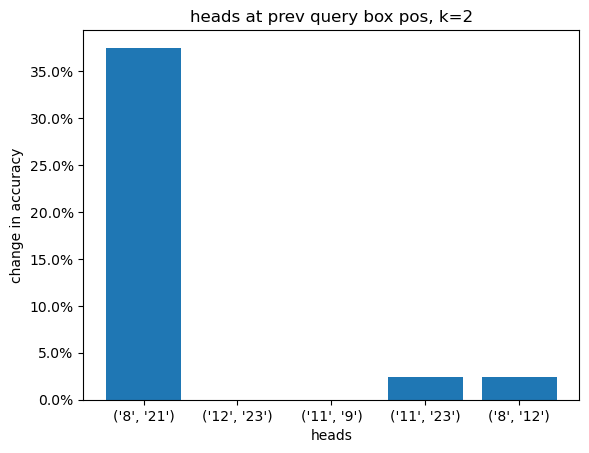

In [38]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

names = []
scores = []

for k in res:
    # new_k = string_to_tuple(k)
    names.append(str((k[0].split(".")[2], str(k[1]))))
    scores.append((res[k][0] / res[k][1] - 1))

plt.bar(names, scores)
plt.title("heads at prev query box pos, k=2")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

In [39]:
new = {}
for k in res:
    new[str(k)] = res[k]


with open(
    "./post-submission/llama-7b/llama_heads_at_prev_box_pos_res_k_2.json", "w"
) as outfile:
    json.dump(new, outfile)

### llama_head_at_query_box_token

In [41]:
import json

with open("./post-submission/llama-7b/head_at_query_box_token.json", "r") as f:
    data = json.load(f)

ranked = defaultdict(list)
for k_1 in data:
    for k_2 in data[k_1]:
        ranked[k_1].append((k_2, data[k_2][k_2] - data[k_1][k_2]))
for k_1 in ranked:
    ranked[k_1].sort(key=(lambda x: x[1]), reverse=True)

In [42]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

res = {}

root_path = "../new_pp_exps/post_submission/llama-7b"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx, head in tqdm(head_at_query_box_token):
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"

    print(layer, head)
    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        print("remove", top_layer, top_head)
        circuit_components[2][top_layer].remove(top_head)

    befor = eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[2][layer].remove(head)
    after = eval(model, dataloader, modules, circuit_components, mean_activations)
    res[(layer, head)] = (befor, after)

    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        circuit_components[2][top_layer].append(top_head)
    circuit_components[2][layer].append(head)

50 15 30 5



  0%|          | 0/30 [00:00<?, ?it/s]

model.layers.10.self_attn.o_proj 3
remove model.layers.9.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 17
remove model.layers.7.self_attn.o_proj 3
remove model.layers.6.self_attn.o_proj 10
remove model.layers.11.self_attn.o_proj 7
remove model.layers.10.self_attn.o_proj 4
remove model.layers.9.self_attn.o_proj 2
remove model.layers.7.self_attn.o_proj 26



100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.49



  3%|▎         | 1/30 [02:05<1:00:38, 125.47s/it]

Task accuracy: 0.17
model.layers.13.self_attn.o_proj 14
remove model.layers.9.self_attn.o_proj 2
remove model.layers.6.self_attn.o_proj 10
remove model.layers.9.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 23
remove model.layers.7.self_attn.o_proj 17
remove model.layers.4.self_attn.o_proj 4
remove model.layers.9.self_attn.o_proj 10
remove model.layers.11.self_attn.o_proj 7
remove model.layers.10.self_attn.o_proj 7



100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.3



  7%|▋         | 2/30 [04:11<58:34, 125.51s/it]  

Task accuracy: 0.22
model.layers.9.self_attn.o_proj 2



100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Task accuracy: 0.57



 10%|█         | 3/30 [06:16<56:23, 125.32s/it]

Task accuracy: 0.61
model.layers.11.self_attn.o_proj 23
remove model.layers.13.self_attn.o_proj 14
remove model.layers.5.self_attn.o_proj 7
remove model.layers.9.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 9
remove model.layers.8.self_attn.o_proj 1
remove model.layers.11.self_attn.o_proj 24
remove model.layers.13.self_attn.o_proj 0
remove model.layers.11.self_attn.o_proj 7



100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.55



 13%|█▎        | 4/30 [08:22<54:24, 125.56s/it]

Task accuracy: 0.52
model.layers.1.self_attn.o_proj 9
remove model.layers.7.self_attn.o_proj 3
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 9
remove model.layers.9.self_attn.o_proj 2
remove model.layers.13.self_attn.o_proj 0
remove model.layers.6.self_attn.o_proj 10
remove model.layers.11.self_attn.o_proj 7
remove model.layers.12.self_attn.o_proj 23
remove model.layers.10.self_attn.o_proj 21



100%|██████████| 10/10 [01:04<00:00,  6.40s/it]


Task accuracy: 0.51



 17%|█▋        | 5/30 [10:30<52:42, 126.51s/it]

Task accuracy: 0.51
model.layers.9.self_attn.o_proj 7



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.57



 20%|██        | 6/30 [12:38<50:51, 127.17s/it]

Task accuracy: 0.6
model.layers.9.self_attn.o_proj 10
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 9
remove model.layers.10.self_attn.o_proj 7
remove model.layers.13.self_attn.o_proj 14
remove model.layers.6.self_attn.o_proj 10
remove model.layers.11.self_attn.o_proj 7
remove model.layers.9.self_attn.o_proj 7
remove model.layers.7.self_attn.o_proj 17
remove model.layers.8.self_attn.o_proj 1



100%|██████████| 10/10 [01:03<00:00,  6.35s/it]


Task accuracy: 0.49



 23%|██▎       | 7/30 [14:45<48:40, 127.00s/it]

Task accuracy: 0.37
model.layers.7.self_attn.o_proj 17
remove model.layers.6.self_attn.o_proj 10
remove model.layers.7.self_attn.o_proj 9
remove model.layers.9.self_attn.o_proj 2
remove model.layers.9.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4



100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Task accuracy: 0.54



 27%|██▋       | 8/30 [16:53<46:42, 127.40s/it]

Task accuracy: 0.5
model.layers.11.self_attn.o_proj 24
remove model.layers.7.self_attn.o_proj 9



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.57



 30%|███       | 9/30 [19:01<44:40, 127.64s/it]

Task accuracy: 0.58
model.layers.7.self_attn.o_proj 26
remove model.layers.6.self_attn.o_proj 10
remove model.layers.9.self_attn.o_proj 2



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.6



 33%|███▎      | 10/30 [21:09<42:36, 127.83s/it]

Task accuracy: 0.58
model.layers.4.self_attn.o_proj 4
remove model.layers.6.self_attn.o_proj 10
remove model.layers.10.self_attn.o_proj 3
remove model.layers.9.self_attn.o_proj 7
remove model.layers.7.self_attn.o_proj 17
remove model.layers.7.self_attn.o_proj 9



100%|██████████| 10/10 [01:04<00:00,  6.43s/it]


Task accuracy: 0.41



 37%|███▋      | 11/30 [23:18<40:32, 128.03s/it]

Task accuracy: 0.37
model.layers.13.self_attn.o_proj 0
remove model.layers.6.self_attn.o_proj 10



100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Task accuracy: 0.57



 40%|████      | 12/30 [25:26<38:26, 128.11s/it]

Task accuracy: 0.56
model.layers.6.self_attn.o_proj 10
remove model.layers.4.self_attn.o_proj 4
remove model.layers.9.self_attn.o_proj 2
remove model.layers.7.self_attn.o_proj 17
remove model.layers.7.self_attn.o_proj 26
remove model.layers.7.self_attn.o_proj 9
remove model.layers.10.self_attn.o_proj 7
remove model.layers.13.self_attn.o_proj 14
remove model.layers.9.self_attn.o_proj 7
remove model.layers.7.self_attn.o_proj 3



100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Task accuracy: 0.49



 43%|████▎     | 13/30 [27:33<36:10, 127.68s/it]

Task accuracy: 0.39
model.layers.7.self_attn.o_proj 9
remove model.layers.6.self_attn.o_proj 10
remove model.layers.7.self_attn.o_proj 17
remove model.layers.9.self_attn.o_proj 2
remove model.layers.5.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4



100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


Task accuracy: 0.54



 47%|████▋     | 14/30 [29:40<34:00, 127.55s/it]

Task accuracy: 0.53
model.layers.5.self_attn.o_proj 7
remove model.layers.10.self_attn.o_proj 7
remove model.layers.7.self_attn.o_proj 9
remove model.layers.11.self_attn.o_proj 23
remove model.layers.12.self_attn.o_proj 23
remove model.layers.4.self_attn.o_proj 4
remove model.layers.11.self_attn.o_proj 24
remove model.layers.13.self_attn.o_proj 0
remove model.layers.11.self_attn.o_proj 7
remove model.layers.9.self_attn.o_proj 15



100%|██████████| 10/10 [01:04<00:00,  6.45s/it]


Task accuracy: 0.55



 50%|█████     | 15/30 [31:49<31:58, 127.90s/it]

Task accuracy: 0.54
model.layers.12.self_attn.o_proj 0
remove model.layers.11.self_attn.o_proj 7
remove model.layers.1.self_attn.o_proj 9
remove model.layers.9.self_attn.o_proj 7
remove model.layers.5.self_attn.o_proj 7
remove model.layers.12.self_attn.o_proj 9
remove model.layers.10.self_attn.o_proj 4
remove model.layers.13.self_attn.o_proj 26
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 9



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.55



 53%|█████▎    | 16/30 [33:57<29:52, 128.03s/it]

Task accuracy: 0.55
model.layers.8.self_attn.o_proj 1



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.57



 57%|█████▋    | 17/30 [36:06<27:45, 128.10s/it]

Task accuracy: 0.58
model.layers.9.self_attn.o_proj 29
remove model.layers.6.self_attn.o_proj 10
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 9
remove model.layers.10.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 24
remove model.layers.13.self_attn.o_proj 0
remove model.layers.11.self_attn.o_proj 7
remove model.layers.10.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 17



100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


Task accuracy: 0.53



 60%|██████    | 18/30 [38:11<25:29, 127.42s/it]

Task accuracy: 0.52
model.layers.12.self_attn.o_proj 9
remove model.layers.11.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4



100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Task accuracy: 0.56



 63%|██████▎   | 19/30 [40:17<23:15, 126.88s/it]

Task accuracy: 0.56
model.layers.7.self_attn.o_proj 3
remove model.layers.9.self_attn.o_proj 2
remove model.layers.1.self_attn.o_proj 9
remove model.layers.6.self_attn.o_proj 10



100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.6



 67%|██████▋   | 20/30 [42:22<21:04, 126.45s/it]

Task accuracy: 0.6
model.layers.11.self_attn.o_proj 7
remove model.layers.10.self_attn.o_proj 7
remove model.layers.12.self_attn.o_proj 23
remove model.layers.7.self_attn.o_proj 26
remove model.layers.7.self_attn.o_proj 9
remove model.layers.8.self_attn.o_proj 1



100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.6



 70%|███████   | 21/30 [44:28<18:55, 126.17s/it]

Task accuracy: 0.6
model.layers.12.self_attn.o_proj 23
remove model.layers.5.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 7
remove model.layers.1.self_attn.o_proj 9
remove model.layers.9.self_attn.o_proj 7
remove model.layers.6.self_attn.o_proj 10
remove model.layers.13.self_attn.o_proj 26
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 9
remove model.layers.8.self_attn.o_proj 1



100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.52



 73%|███████▎  | 22/30 [46:34<16:48, 126.06s/it]

Task accuracy: 0.52
model.layers.9.self_attn.o_proj 15
remove model.layers.9.self_attn.o_proj 2
remove model.layers.9.self_attn.o_proj 7
remove model.layers.6.self_attn.o_proj 10
remove model.layers.5.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4
remove model.layers.8.self_attn.o_proj 1



100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.58



 77%|███████▋  | 23/30 [48:39<14:41, 125.89s/it]

Task accuracy: 0.57
model.layers.10.self_attn.o_proj 21
remove model.layers.1.self_attn.o_proj 9
remove model.layers.5.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 7
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 3
remove model.layers.11.self_attn.o_proj 23
remove model.layers.9.self_attn.o_proj 10
remove model.layers.11.self_attn.o_proj 24
remove model.layers.13.self_attn.o_proj 0



100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.46



 80%|████████  | 24/30 [50:45<12:34, 125.76s/it]

Task accuracy: 0.45
model.layers.9.self_attn.o_proj 21
remove model.layers.5.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 7
remove model.layers.10.self_attn.o_proj 4
remove model.layers.9.self_attn.o_proj 7
remove model.layers.8.self_attn.o_proj 1
remove model.layers.13.self_attn.o_proj 14
remove model.layers.12.self_attn.o_proj 9
remove model.layers.9.self_attn.o_proj 15
remove model.layers.4.self_attn.o_proj 4



100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.56



 83%|████████▎ | 25/30 [52:50<10:28, 125.65s/it]

Task accuracy: 0.43
model.layers.10.self_attn.o_proj 4
remove model.layers.9.self_attn.o_proj 7
remove model.layers.7.self_attn.o_proj 9
remove model.layers.10.self_attn.o_proj 3
remove model.layers.11.self_attn.o_proj 24
remove model.layers.5.self_attn.o_proj 7
remove model.layers.9.self_attn.o_proj 29
remove model.layers.11.self_attn.o_proj 7
remove model.layers.9.self_attn.o_proj 21
remove model.layers.10.self_attn.o_proj 7



100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Task accuracy: 0.41



 87%|████████▋ | 26/30 [54:55<08:22, 125.57s/it]

Task accuracy: 0.41
model.layers.10.self_attn.o_proj 7



100%|██████████| 10/10 [01:03<00:00,  6.30s/it]


Task accuracy: 0.57



 90%|█████████ | 27/30 [57:01<06:16, 125.65s/it]

Task accuracy: 0.59
model.layers.13.self_attn.o_proj 26
remove model.layers.11.self_attn.o_proj 7
remove model.layers.12.self_attn.o_proj 23
remove model.layers.8.self_attn.o_proj 1



100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Task accuracy: 0.58



 93%|█████████▎| 28/30 [59:06<04:10, 125.49s/it]

Task accuracy: 0.58
model.layers.13.self_attn.o_proj 12
remove model.layers.9.self_attn.o_proj 2
remove model.layers.6.self_attn.o_proj 10
remove model.layers.11.self_attn.o_proj 7



100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.6



 97%|█████████▋| 29/30 [1:01:12<02:05, 125.44s/it]

Task accuracy: 0.59
model.layers.8.self_attn.o_proj 12
remove model.layers.10.self_attn.o_proj 4
remove model.layers.9.self_attn.o_proj 7
remove model.layers.11.self_attn.o_proj 7
remove model.layers.10.self_attn.o_proj 7
remove model.layers.13.self_attn.o_proj 26
remove model.layers.7.self_attn.o_proj 17
remove model.layers.4.self_attn.o_proj 4
remove model.layers.7.self_attn.o_proj 9
remove model.layers.13.self_attn.o_proj 14



100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Task accuracy: 0.56



100%|██████████| 30/30 [1:03:17<00:00, 126.58s/it]

Task accuracy: 0.51


In [49]:
# with open("llama_head_at_query_box_token_res_k_10.json", "r") as file:
#     res = json.load(file)

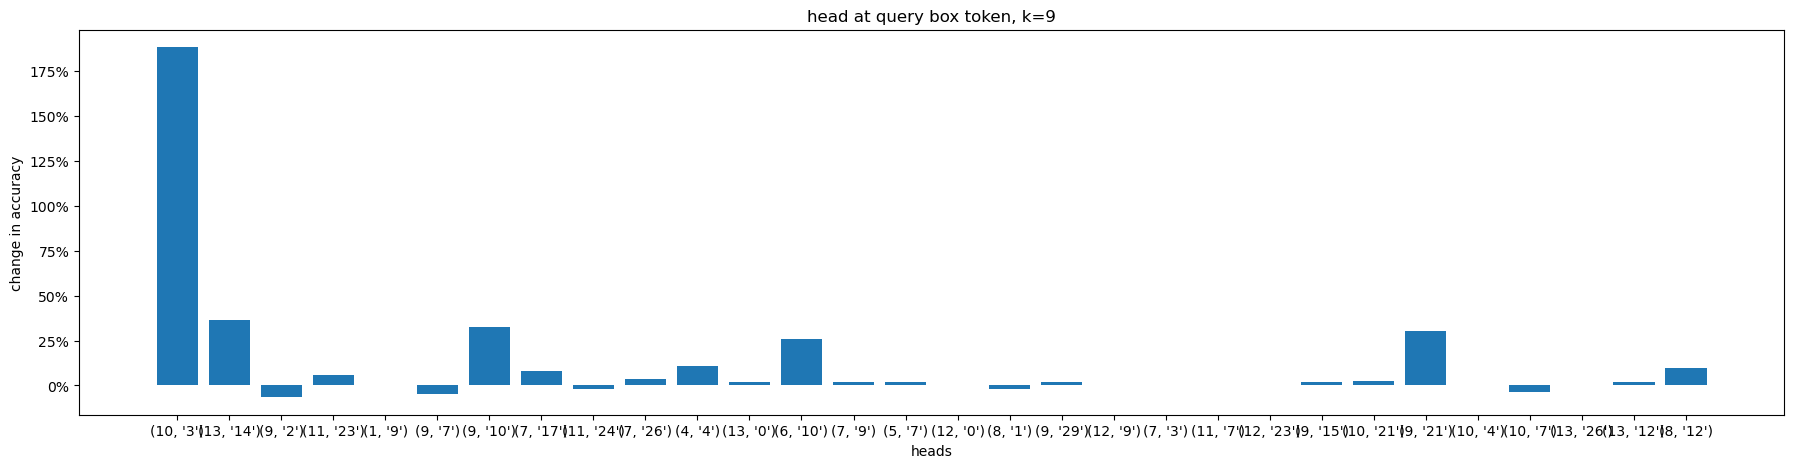

In [43]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

names = []
scores = []

for k in res:
    new_k = string_to_tuple(str(k))
    names.append(str((int(new_k[0].split(".")[2]), new_k[1])))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(22, 5))
plt.bar(names, scores)
plt.title("head at query box token, k=9")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

In [44]:
new = {}
for k in res:
    new[str(k)] = res[k]

with open(
    "./post-submission/llama-7b/llama_head_at_query_box_token_res_k_9.json", "w"
) as outfile:
    json.dump(new, outfile)

### llama_heads_affecting_direct_logit_heads

In [46]:
import json

with open(
    "./post-submission/llama-7b/heads_affecting_direct_logit_heads.json", "r"
) as f:
    data = json.load(f)

ranked = defaultdict(list)
for k_1 in data:
    for k_2 in data[k_1]:
        ranked[k_1].append((k_2, data[k_2][k_2] - data[k_1][k_2]))
for k_1 in ranked:
    ranked[k_1].sort(key=(lambda x: x[1]), reverse=True)

In [47]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

res = {}

root_path = "../new_pp_exps/post_submission/llama-7b"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx, head in tqdm(heads_affecting_direct_logit_heads):
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    print(layer, head)

    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        print("remove", top_layer, top_head)
        circuit_components[0][top_layer].remove(top_head)

    befor = eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[0][layer].remove(head)
    after = eval(model, dataloader, modules, circuit_components, mean_activations)
    res[(layer, head)] = (befor, after)

    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        circuit_components[0][top_layer].append(top_head)
    circuit_components[0][layer].append(head)

50 15 30 5



  0%|          | 0/15 [00:00<?, ?it/s]

model.layers.14.self_attn.o_proj 27
remove model.layers.11.self_attn.o_proj 23
remove model.layers.13.self_attn.o_proj 14
remove model.layers.12.self_attn.o_proj 23
remove model.layers.17.self_attn.o_proj 26
remove model.layers.14.self_attn.o_proj 0



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.53



  7%|▋         | 1/15 [02:07<29:51, 127.98s/it]

Task accuracy: 0.15
model.layers.11.self_attn.o_proj 23
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23
remove model.layers.11.self_attn.o_proj 26
remove model.layers.17.self_attn.o_proj 26
remove model.layers.19.self_attn.o_proj 12



100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Task accuracy: 0.4



 13%|█▎        | 2/15 [04:15<27:39, 127.69s/it]

Task accuracy: 0.15
model.layers.12.self_attn.o_proj 23
remove model.layers.14.self_attn.o_proj 27
remove model.layers.13.self_attn.o_proj 14
remove model.layers.19.self_attn.o_proj 12
remove model.layers.11.self_attn.o_proj 26
remove model.layers.10.self_attn.o_proj 6



100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Task accuracy: 0.42



 20%|██        | 3/15 [06:21<25:25, 127.10s/it]

Task accuracy: 0.28
model.layers.19.self_attn.o_proj 12
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Task accuracy: 0.42



 27%|██▋       | 4/15 [08:29<23:21, 127.40s/it]

Task accuracy: 0.39
model.layers.13.self_attn.o_proj 0
remove model.layers.14.self_attn.o_proj 27
remove model.layers.19.self_attn.o_proj 12
remove model.layers.16.self_attn.o_proj 2
remove model.layers.11.self_attn.o_proj 26
remove model.layers.14.self_attn.o_proj 0



100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Task accuracy: 0.42



 33%|███▎      | 5/15 [10:38<21:17, 127.77s/it]

Task accuracy: 0.36
model.layers.16.self_attn.o_proj 2
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23
remove model.layers.13.self_attn.o_proj 0
remove model.layers.17.self_attn.o_proj 26
remove model.layers.13.self_attn.o_proj 14



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.29



 40%|████      | 6/15 [12:46<19:11, 127.92s/it]

Task accuracy: 0.27
model.layers.13.self_attn.o_proj 1
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23
remove model.layers.19.self_attn.o_proj 12
remove model.layers.16.self_attn.o_proj 2
remove model.layers.11.self_attn.o_proj 26



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.39



 47%|████▋     | 7/15 [14:54<17:04, 128.02s/it]

Task accuracy: 0.38
model.layers.11.self_attn.o_proj 26
remove model.layers.17.self_attn.o_proj 26
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:04<00:00,  6.43s/it]


Task accuracy: 0.41



 53%|█████▎    | 8/15 [17:03<14:57, 128.17s/it]

Task accuracy: 0.4
model.layers.13.self_attn.o_proj 14
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.42



 60%|██████    | 9/15 [19:11<12:49, 128.18s/it]

Task accuracy: 0.35
model.layers.16.self_attn.o_proj 16
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Task accuracy: 0.57



 67%|██████▋   | 10/15 [21:19<10:41, 128.23s/it]

Task accuracy: 0.57
model.layers.14.self_attn.o_proj 0
remove model.layers.14.self_attn.o_proj 27



100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Task accuracy: 0.48



 73%|███████▎  | 11/15 [23:27<08:33, 128.27s/it]

Task accuracy: 0.46
model.layers.14.self_attn.o_proj 13
remove model.layers.14.self_attn.o_proj 27
remove model.layers.11.self_attn.o_proj 26



100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Task accuracy: 0.48



 80%|████████  | 12/15 [25:35<06:24, 128.15s/it]

Task accuracy: 0.46
model.layers.10.self_attn.o_proj 6
remove model.layers.12.self_attn.o_proj 23
remove model.layers.14.self_attn.o_proj 27



100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Task accuracy: 0.42



 87%|████████▋ | 13/15 [27:44<04:16, 128.22s/it]

Task accuracy: 0.37
model.layers.17.self_attn.o_proj 26
remove model.layers.14.self_attn.o_proj 27



100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Task accuracy: 0.48



 93%|█████████▎| 14/15 [29:51<02:07, 127.89s/it]

Task accuracy: 0.46
model.layers.12.self_attn.o_proj 0
remove model.layers.14.self_attn.o_proj 27
remove model.layers.12.self_attn.o_proj 23



100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Task accuracy: 0.42



100%|██████████| 15/15 [31:57<00:00, 127.80s/it]

Task accuracy: 0.4


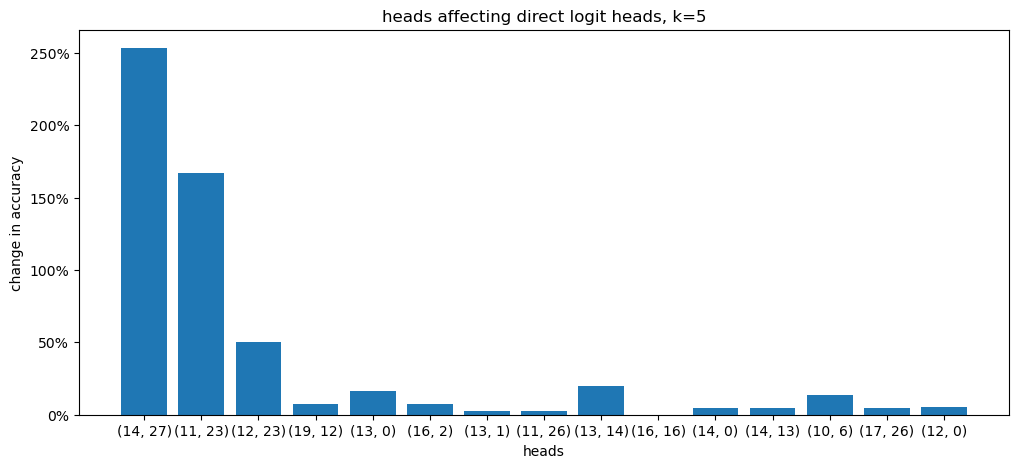

In [49]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_heads_affecting_direct_logit_heads_res_k_5.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    new_k = str(k)
    names.append(str((int(new_k.split(".")[2]), int(new_k.split(",")[1][1:-1]))))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(12, 5))
plt.bar(names, scores)
plt.title("heads affecting direct logit heads, k=5")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

In [50]:
new = {}
for k in res:
    new[str(k)] = res[k]

with open(
    "./post-submission/llama-7b/llama_heads_affecting_direct_logit_heads_res_k_5.json",
    "w",
) as outfile:
    json.dump(new, outfile)

### llama_direct_logit_heads

In [28]:
import json

with open("./post-submission/llama-7b/direct_logit_heads.json", "r") as f:
    data = json.load(f)

ranked = defaultdict(list)
for k_1 in data:
    for k_2 in data[k_1]:
        ranked[k_1].append((k_2, data[k_2][k_2] - data[k_1][k_2]))
for k_1 in ranked:
    ranked[k_1].sort(key=(lambda x: x[1]), reverse=True)

In [29]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

percentage = 0.5
res = {}

root_path = "../new_pp_exps/post_submission/llama-7b"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)


for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)

for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)


for layer_idx, head in tqdm(direct_logit_heads):
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"

    print(layer, head)
    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        print("remove", top_layer, top_head)
        circuit_components[0][top_layer].remove(top_head)

    befor = eval(model, dataloader, modules, circuit_components, mean_activations)
    circuit_components[0][layer].remove(head)
    after = eval(model, dataloader, modules, circuit_components, mean_activations)
    res[(layer, head)] = (befor, after)

    for r in ranked[str((layer, head))][: math.ceil(percentage * len(ranked.values()))]:
        top_layer = r[0].split(",")[0][2:-1]
        top_head = int(r[0].split(",")[1][:-1])
        if r[1] <= 0:
            break
        circuit_components[0][top_layer].append(top_head)
    circuit_components[0][layer].append(head)

50 15 30 5



  0%|          | 0/50 [00:00<?, ?it/s]

model.layers.15.self_attn.o_proj 13
remove model.layers.23.self_attn.o_proj 5
remove model.layers.21.self_attn.o_proj 26
remove model.layers.16.self_attn.o_proj 27
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 23
remove model.layers.18.self_attn.o_proj 8
remove model.layers.24.self_attn.o_proj 5
remove model.layers.29.self_attn.o_proj 7
remove model.layers.17.self_attn.o_proj 27
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 25
remove model.layers.19.self_attn.o_proj 8
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 18
remove model.layers.30.self_attn.o_proj 4
remove model.layers.18.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 5
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.17.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 17
remove model.layers.21.self_


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.39



  2%|▏         | 1/50 [01:15<1:01:28, 75.28s/it]

Task accuracy: 0.36
model.layers.21.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 8
remove model.layers.23.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 1
remove model.layers.21.self_attn.o_proj 23
remove model.layers.15.self_attn.o_proj 18
remove model.layers.30.self_attn.o_proj 4
remove model.layers.29.self_attn.o_proj 7
remove model.layers.23.self_attn.o_proj 15
remove model.layers.21.self_attn.o_proj 4
remove model.layers.17.self_attn.o_proj 27
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.31.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 30
remove model.layers.21.self_attn.o_proj 0
remove model.layers.28.self_attn.o_proj 16
remove model.layers.23.self_attn.o_proj 19
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.19.self_attn.o_proj 8
remove m


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.37



  4%|▍         | 2/50 [02:30<1:00:13, 75.28s/it]

Task accuracy: 0.35
model.layers.15.self_attn.o_proj 18
remove model.layers.16.self_attn.o_proj 27
remove model.layers.21.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 13
remove model.layers.21.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 5
remove model.layers.17.self_attn.o_proj 27
remove model.layers.19.self_attn.o_proj 30
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 17
remove model.layers.23.self_attn.o_proj 19
remove model.layers.14.self_attn.o_proj 11
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.15.self_attn.o_proj 9
remove model.layers.18.self_attn.o_proj 6
remove model.layers.19.self_attn.o_proj 25
remove model.layers.19.self_attn.o_proj 11
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remo


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.46



  6%|▌         | 3/50 [03:46<59:06, 75.45s/it]  

Task accuracy: 0.43
model.layers.30.self_attn.o_proj 4
remove model.layers.15.self_attn.o_proj 13
remove model.layers.21.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 5
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.31.self_attn.o_proj 29
remove model.layers.19.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 25
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.48



  8%|▊         | 4/50 [05:01<57:54, 75.52s/it]

Task accuracy: 0.48
model.layers.18.self_attn.o_proj 8
remove model.layers.15.self_attn.o_proj 13
remove model.layers.21.self_attn.o_proj 3
remove model.layers.24.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 5
remove model.layers.17.self_attn.o_proj 27
remove model.layers.23.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 17
remove model.layers.24.self_attn.o_proj 8



100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.5



 10%|█         | 5/50 [06:17<56:37, 75.49s/it]

Task accuracy: 0.48
model.layers.24.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 13
remove model.layers.18.self_attn.o_proj 8
remove model.layers.19.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 4
remove model.layers.23.self_attn.o_proj 5
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 17
remove model.layers.31.self_attn.o_proj 29
remove model.layers.18.self_attn.o_proj 6
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 23
remove model.layers.21.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 18
remove model.layers.30.self_attn.o_proj 4
remove model.layers.29.self_attn.o_proj 7
remove model.layers.18.self_attn.o_proj 3
remove model.layers.17.self_attn.o_proj 28
remove model.layers.15.self_attn.o_proj 5
remove mode


100%|██████████| 6/6 [00:37<00:00,  6.33s/it]


Task accuracy: 0.32



 12%|█▏        | 6/50 [07:33<55:27, 75.62s/it]

Task accuracy: 0.29
model.layers.29.self_attn.o_proj 7
remove model.layers.15.self_attn.o_proj 13
remove model.layers.23.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 30



100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.51



 14%|█▍        | 7/50 [08:48<54:11, 75.61s/it]

Task accuracy: 0.5
model.layers.18.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 5
remove model.layers.21.self_attn.o_proj 23
remove model.layers.15.self_attn.o_proj 13
remove model.layers.29.self_attn.o_proj 7
remove model.layers.15.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 20
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 30
remove model.layers.14.self_attn.o_proj 11
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.16.self_attn.o_proj 27
remove model.layers.15.self_attn.o_proj 9
remove model.layers.18.self_attn.o_proj 6
remove model.layers.15.self_attn.o_proj 12
remove model.layers.18.self_attn.o_proj 25
remove model.layers.19.self_attn.o_proj 11
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.15.self_attn.o_proj 18
remove 


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.41



 16%|█▌        | 8/50 [10:04<52:57, 75.66s/it]

Task accuracy: 0.41
model.layers.23.self_attn.o_proj 15
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 19
remove model.layers.19.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.53



 18%|█▊        | 9/50 [11:20<51:41, 75.64s/it]

Task accuracy: 0.53
model.layers.20.self_attn.o_proj 14
remove model.layers.24.self_attn.o_proj 8
remove model.layers.23.self_attn.o_proj 15
remove model.layers.17.self_attn.o_proj 27
remove model.layers.31.self_attn.o_proj 26
remove model.layers.19.self_attn.o_proj 25
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 23
remove model.layers.15.self_attn.o_proj 13
remove model.layers.21.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 18
remove model.layers.18.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 3
remove model.layers.17.self_attn.o_proj 28
remove model.layers.21.self_attn.o_proj 4
remove model.layers.15.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 20
remove model.layers.19.self_attn.o_proj 2
remove model.layers.21.self_attn.o_proj 25
remove model.layers.15.self_attn.o_proj 2
remove m


100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.32



 20%|██        | 10/50 [12:35<50:26, 75.67s/it]

Task accuracy: 0.29
model.layers.17.self_attn.o_proj 28
remove model.layers.23.self_attn.o_proj 5
remove model.layers.17.self_attn.o_proj 27
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 17
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.16.self_attn.o_proj 27
remove model.layers.21.self_attn.o_proj 19
remove model.layers.18.self_attn.o_proj 6
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 23
remove model.layers.21.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 18
remove model.layers.18.self_attn.o_proj 8
remove model.layers.24.self_attn.o_proj 5
remove model.layers.18.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 15
remove model.layers.20.self_attn.o_proj 14
remove model.layers.21.self_attn.o_proj 4
remove


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.4



 22%|██▏       | 11/50 [13:51<49:12, 75.71s/it]

Task accuracy: 0.35
model.layers.21.self_attn.o_proj 4
remove model.layers.23.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 25
remove model.layers.19.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 25
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 23
remove model.layers.21.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 8
remove model.layers.24.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 15
remove model.layers.23.self_attn.o_proj 5
remove model.layers.17.self_attn.o_proj 27
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 17
remove model.layers.28.self_attn.o_proj 16
remove model.layers.23.self_attn.o_proj 19
remove 


100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


Task accuracy: 0.35



 24%|██▍       | 12/50 [15:07<47:59, 75.78s/it]

Task accuracy: 0.29
model.layers.15.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 13
remove model.layers.18.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 5
remove model.layers.17.self_attn.o_proj 27
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.31.self_attn.o_proj 25
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.16.self_attn.o_proj 27
remove model.layers.18.self_attn.o_proj 6
remove model.layers.18.self_attn.o_proj 25
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8



100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.48



 26%|██▌       | 13/50 [16:23<46:44, 75.79s/it]

Task accuracy: 0.49
model.layers.23.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 13
remove model.layers.16.self_attn.o_proj 27
remove model.layers.21.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 8
remove model.layers.29.self_attn.o_proj 7
remove model.layers.18.self_attn.o_proj 3
remove model.layers.31.self_attn.o_proj 25
remove model.layers.14.self_attn.o_proj 11
remove model.layers.15.self_attn.o_proj 12
remove model.layers.19.self_attn.o_proj 11



100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.47



 28%|██▊       | 14/50 [17:39<45:28, 75.78s/it]

Task accuracy: 0.46
model.layers.17.self_attn.o_proj 27
remove model.layers.21.self_attn.o_proj 23
remove model.layers.15.self_attn.o_proj 13
remove model.layers.18.self_attn.o_proj 8
remove model.layers.19.self_attn.o_proj 2
remove model.layers.23.self_attn.o_proj 19
remove model.layers.21.self_attn.o_proj 26
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 18
remove model.layers.23.self_attn.o_proj 15
remove model.layers.20.self_attn.o_proj 14
remove model.layers.17.self_attn.o_proj 28
remove model.layers.21.self_attn.o_proj 4
remove model.layers.15.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 2
remove model.layers.17.self_attn.o_proj 3
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 17
remove model.layers.19.self_attn.o_proj 8
remove model.layers.16.self_attn.o_proj 27
remove model.layers.21.self_attn.o_proj 19
remove 


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.34



 30%|███       | 15/50 [18:54<44:11, 75.74s/it]

Task accuracy: 0.31
model.layers.28.self_attn.o_proj 17
remove model.layers.23.self_attn.o_proj 5
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 17
remove model.layers.31.self_attn.o_proj 29
remove model.layers.16.self_attn.o_proj 27
remove model.layers.15.self_attn.o_proj 9
remove model.layers.18.self_attn.o_proj 6
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.56



 32%|███▏      | 16/50 [20:10<42:54, 75.72s/it]

Task accuracy: 0.54
model.layers.19.self_attn.o_proj 30
remove model.layers.16.self_attn.o_proj 27
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 23
remove model.layers.15.self_attn.o_proj 18
remove model.layers.23.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 20
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 30
remove model.layers.28.self_attn.o_proj 16
remove model.layers.31.self_attn.o_proj 29
remove model.layers.21.self_attn.o_proj 19
remove model.layers.18.self_attn.o_proj 25
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remove model.layers.15.self_attn.o_proj 13
remove model.layers.21.self_attn.o_proj 3
remove model.layers.30.self_attn.o_proj 4
remove model.layers.18.self_attn.o_proj 8
remove model.layers.24.self_attn.o_proj 5
remove model.layers.29.self_attn.o_proj 7
remove


100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.37



 34%|███▍      | 17/50 [21:26<41:40, 75.76s/it]

Task accuracy: 0.34
model.layers.24.self_attn.o_proj 8



100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.56



 36%|███▌      | 18/50 [22:41<40:22, 75.71s/it]

Task accuracy: 0.57
model.layers.18.self_attn.o_proj 28
remove model.layers.21.self_attn.o_proj 23
remove model.layers.23.self_attn.o_proj 5
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.16.self_attn.o_proj 27
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 3
remove model.layers.21.self_attn.o_proj 4
remove model.layers.23.self_attn.o_proj 20
remove model.layers.15.self_attn.o_proj 2
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 19
remove model.layers.19.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 19
remove model.layers.18.self_attn.o_proj 6
remove model.layers.19.self_attn.o_proj 25
remove m


100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.43



 38%|███▊      | 19/50 [23:57<39:07, 75.72s/it]

Task accuracy: 0.41
model.layers.23.self_attn.o_proj 20
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 23
remove model.layers.18.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 4
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 19
remove model.layers.24.self_attn.o_proj 8



100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.55



 40%|████      | 20/50 [25:13<37:50, 75.69s/it]

Task accuracy: 0.5
model.layers.19.self_attn.o_proj 2
remove model.layers.15.self_attn.o_proj 13
remove model.layers.17.self_attn.o_proj 27
remove model.layers.21.self_attn.o_proj 3
remove model.layers.30.self_attn.o_proj 4
remove model.layers.18.self_attn.o_proj 8
remove model.layers.24.self_attn.o_proj 5
remove model.layers.29.self_attn.o_proj 7
remove model.layers.18.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 15
remove model.layers.21.self_attn.o_proj 4
remove model.layers.23.self_attn.o_proj 5
remove model.layers.18.self_attn.o_proj 28
remove model.layers.15.self_attn.o_proj 6
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.17.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 17
remove model.layers.14.self_attn.o_proj 11
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.16.self_attn.o_proj 27
remove mod


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.27



 42%|████▏     | 21/50 [26:29<36:35, 75.72s/it]

Task accuracy: 0.26
model.layers.15.self_attn.o_proj 6
remove model.layers.23.self_attn.o_proj 5
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 25
remove model.layers.31.self_attn.o_proj 29
remove model.layers.25.self_attn.o_proj 19
remove model.layers.24.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 23
remove model.layers.18.self_attn.o_proj 3
remove model.layers.17.self_attn.o_proj 27
remove model.layers.28.self_attn.o_proj 17
remove model.layers.31.self_attn.o_proj 26
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 19
remove model.layers.21.self_attn.o_proj 26
remove model.layers.19.self_attn.o_proj 8
remove model.layers.16.self_attn.o_proj 27
remove model.layers.18.self_attn.o_proj 6
remove model.layers.15.self_attn.o_proj 12
remove model.layers.19.self_attn.o_proj 26
remove model.layers.22.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 1



100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.49



 44%|████▍     | 22/50 [27:44<35:19, 75.68s/it]

Task accuracy: 0.45
model.layers.31.self_attn.o_proj 26
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.57



 46%|████▌     | 23/50 [29:00<34:02, 75.64s/it]

Task accuracy: 0.57
model.layers.21.self_attn.o_proj 25
remove model.layers.21.self_attn.o_proj 4
remove model.layers.23.self_attn.o_proj 30
remove model.layers.16.self_attn.o_proj 27
remove model.layers.24.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 23
remove model.layers.15.self_attn.o_proj 13
remove model.layers.21.self_attn.o_proj 3
remove model.layers.30.self_attn.o_proj 4
remove model.layers.18.self_attn.o_proj 8
remove model.layers.23.self_attn.o_proj 15
remove model.layers.15.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 5
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.28.self_attn.o_proj 16
remove model.layers.23.self_attn.o_proj 19
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.18.self_attn.o_proj 6
remove model.layers.19.self_attn.o_proj 11
remove 


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.46



 48%|████▊     | 24/50 [30:15<32:46, 75.64s/it]

Task accuracy: 0.42
model.layers.15.self_attn.o_proj 2
remove model.layers.16.self_attn.o_proj 27
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 15
remove model.layers.23.self_attn.o_proj 5
remove model.layers.17.self_attn.o_proj 27
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.19.self_attn.o_proj 8
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 23
remove model.layers.15.self_attn.o_proj 13
remove model.layers.21.self_attn.o_proj 3
remove model.layers.30.self_attn.o_proj 4
remove model.layers.24.self_attn.o_proj 5
remove model.layers.29.self_attn.o_proj 7
remove model.layers.18.self_attn.o_proj 3
remove model.layers.20.self_attn.o_proj 14
remove model.layers.21.self_attn.o_proj 4
remove model.layers.15.self_attn.o_proj 5
remove mod


100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.32



 50%|█████     | 25/50 [31:31<31:30, 75.64s/it]

Task accuracy: 0.31
model.layers.17.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 13
remove model.layers.23.self_attn.o_proj 15
remove model.layers.17.self_attn.o_proj 27
remove model.layers.23.self_attn.o_proj 20
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 19
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.18.self_attn.o_proj 6
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.46



 52%|█████▏    | 26/50 [32:47<30:14, 75.61s/it]

Task accuracy: 0.46
model.layers.31.self_attn.o_proj 25
remove model.layers.15.self_attn.o_proj 13
remove model.layers.23.self_attn.o_proj 5
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.52



 54%|█████▍    | 27/50 [34:02<28:57, 75.56s/it]

Task accuracy: 0.53
model.layers.18.self_attn.o_proj 20



100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.56



 56%|█████▌    | 28/50 [35:17<27:41, 75.53s/it]

Task accuracy: 0.58
model.layers.23.self_attn.o_proj 30
remove model.layers.29.self_attn.o_proj 7
remove model.layers.23.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 25



100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.55



 58%|█████▊    | 29/50 [36:33<26:26, 75.55s/it]

Task accuracy: 0.54
model.layers.23.self_attn.o_proj 17
remove model.layers.18.self_attn.o_proj 20
remove model.layers.18.self_attn.o_proj 8
remove model.layers.23.self_attn.o_proj 19
remove model.layers.24.self_attn.o_proj 8



100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.56



 60%|██████    | 30/50 [37:48<25:09, 75.46s/it]

Task accuracy: 0.54
model.layers.21.self_attn.o_proj 0
remove model.layers.19.self_attn.o_proj 8
remove model.layers.15.self_attn.o_proj 13
remove model.layers.21.self_attn.o_proj 3
remove model.layers.29.self_attn.o_proj 7
remove model.layers.23.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 20
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 30
remove model.layers.31.self_attn.o_proj 29
remove model.layers.16.self_attn.o_proj 27
remove model.layers.18.self_attn.o_proj 6
remove model.layers.19.self_attn.o_proj 11
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.49



 62%|██████▏   | 31/50 [39:04<23:53, 75.43s/it]

Task accuracy: 0.47
model.layers.28.self_attn.o_proj 16
remove model.layers.15.self_attn.o_proj 13
remove model.layers.21.self_attn.o_proj 3
remove model.layers.21.self_attn.o_proj 4
remove model.layers.23.self_attn.o_proj 5
remove model.layers.19.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 20
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.31.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.16.self_attn.o_proj 27
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8



100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.48



 64%|██████▍   | 32/50 [40:19<22:37, 75.41s/it]

Task accuracy: 0.48
model.layers.23.self_attn.o_proj 19
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 23
remove model.layers.23.self_attn.o_proj 15
remove model.layers.17.self_attn.o_proj 27
remove model.layers.23.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 17
remove model.layers.21.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 18
remove model.layers.18.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 4
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.17.self_attn.o_proj 3
remove model.layers.31.self_attn.o_proj 25
remove model.layers.14.self_attn.o_proj 11
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.19.self_attn.o_proj 8
remove model.layers.16.self_attn.o_proj 27
remove model.layers.21.self_attn.o_proj 19
remove model.layers.25.self_attn.o_proj 19
remove model.layers.24.self_attn.o_proj 8



100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.41



 66%|██████▌   | 33/50 [41:34<21:21, 75.40s/it]

Task accuracy: 0.35
model.layers.14.self_attn.o_proj 11
remove model.layers.23.self_attn.o_proj 5
remove model.layers.15.self_attn.o_proj 18
remove model.layers.18.self_attn.o_proj 3
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 19
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.16.self_attn.o_proj 27
remove model.layers.18.self_attn.o_proj 6
remove model.layers.15.self_attn.o_proj 12
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.5



 68%|██████▊   | 34/50 [42:50<20:06, 75.42s/it]

Task accuracy: 0.49
model.layers.21.self_attn.o_proj 26
remove model.layers.15.self_attn.o_proj 13
remove model.layers.17.self_attn.o_proj 27
remove model.layers.16.self_attn.o_proj 27
remove model.layers.24.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 18
remove model.layers.18.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 3
remove model.layers.17.self_attn.o_proj 28
remove model.layers.21.self_attn.o_proj 4
remove model.layers.15.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 5
remove model.layers.18.self_attn.o_proj 28
remove model.layers.23.self_attn.o_proj 20
remove model.layers.19.self_attn.o_proj 2
remove model.layers.21.self_attn.o_proj 25
remove model.layers.15.self_attn.o_proj 2
remove model.layers.17.self_attn.o_proj 3
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 30
remove model.layers.28.self_attn.o_proj 16
remove model.layers.23.self_attn.o_proj 19
remove m


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.26



 70%|███████   | 35/50 [44:06<18:52, 75.51s/it]

Task accuracy: 0.25
model.layers.31.self_attn.o_proj 29



100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.56



 72%|███████▏  | 36/50 [45:21<17:37, 75.50s/it]

Task accuracy: 0.56
model.layers.19.self_attn.o_proj 8
remove model.layers.15.self_attn.o_proj 13
remove model.layers.24.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 15
remove model.layers.21.self_attn.o_proj 4
remove model.layers.21.self_attn.o_proj 0
remove model.layers.16.self_attn.o_proj 27
remove model.layers.15.self_attn.o_proj 12
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 3
remove model.layers.30.self_attn.o_proj 4
remove model.layers.23.self_attn.o_proj 5
remove model.layers.17.self_attn.o_proj 27
remove model.layers.23.self_attn.o_proj 20
remove model.layers.31.self_attn.o_proj 26
remove model.layers.15.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 17
remove model.layers.23.self_attn.o_proj 19
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.15.self_attn.o_proj 9
remove 


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.29



 74%|███████▍  | 37/50 [46:37<16:21, 75.51s/it]

Task accuracy: 0.27
model.layers.16.self_attn.o_proj 27
remove model.layers.15.self_attn.o_proj 13
remove model.layers.15.self_attn.o_proj 18
remove model.layers.23.self_attn.o_proj 5
remove model.layers.19.self_attn.o_proj 30
remove model.layers.21.self_attn.o_proj 25
remove model.layers.15.self_attn.o_proj 2
remove model.layers.21.self_attn.o_proj 26
remove model.layers.19.self_attn.o_proj 8
remove model.layers.24.self_attn.o_proj 8



100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Task accuracy: 0.47



 76%|███████▌  | 38/50 [47:52<15:04, 75.40s/it]

Task accuracy: 0.46
model.layers.15.self_attn.o_proj 9
remove model.layers.15.self_attn.o_proj 18
remove model.layers.18.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 15
remove model.layers.23.self_attn.o_proj 5
remove model.layers.28.self_attn.o_proj 17
remove model.layers.23.self_attn.o_proj 20
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 17
remove model.layers.31.self_attn.o_proj 29
remove model.layers.19.self_attn.o_proj 8
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


Task accuracy: 0.51



 78%|███████▊  | 39/50 [49:07<13:49, 75.41s/it]

Task accuracy: 0.51
model.layers.21.self_attn.o_proj 23
remove model.layers.15.self_attn.o_proj 13
remove model.layers.17.self_attn.o_proj 27
remove model.layers.23.self_attn.o_proj 20
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 19



100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.51



 80%|████████  | 40/50 [50:23<12:34, 75.46s/it]

Task accuracy: 0.49
model.layers.21.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 18



100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


Task accuracy: 0.53



 82%|████████▏ | 41/50 [51:38<11:18, 75.43s/it]

Task accuracy: 0.52
model.layers.18.self_attn.o_proj 6
remove model.layers.15.self_attn.o_proj 13
remove model.layers.21.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 18
remove model.layers.24.self_attn.o_proj 5
remove model.layers.29.self_attn.o_proj 7
remove model.layers.18.self_attn.o_proj 3
remove model.layers.23.self_attn.o_proj 15
remove model.layers.17.self_attn.o_proj 28
remove model.layers.21.self_attn.o_proj 4
remove model.layers.15.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 5
remove model.layers.28.self_attn.o_proj 17
remove model.layers.23.self_attn.o_proj 20
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.17.self_attn.o_proj 3
remove model.layers.31.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 30
remove model.layers.21.self_attn.o_proj 0
remove model.layers.14.self_attn.o_proj 11
remove mo


100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


Task accuracy: 0.29



 84%|████████▍ | 42/50 [52:54<10:03, 75.47s/it]

Task accuracy: 0.27
model.layers.19.self_attn.o_proj 25
remove model.layers.15.self_attn.o_proj 13
remove model.layers.15.self_attn.o_proj 18
remove model.layers.20.self_attn.o_proj 14
remove model.layers.21.self_attn.o_proj 4
remove model.layers.17.self_attn.o_proj 27
remove model.layers.31.self_attn.o_proj 26
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 26
remove model.layers.15.self_attn.o_proj 1



100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


Task accuracy: 0.42



 86%|████████▌ | 43/50 [54:09<08:48, 75.48s/it]

Task accuracy: 0.42
model.layers.15.self_attn.o_proj 12
remove model.layers.23.self_attn.o_proj 5
remove model.layers.19.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 23
remove model.layers.21.self_attn.o_proj 3
remove model.layers.18.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 3
remove model.layers.21.self_attn.o_proj 4
remove model.layers.23.self_attn.o_proj 20
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 30
remove model.layers.14.self_attn.o_proj 11
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.18.self_attn.o_proj 6
remove model.layers.19.self_attn.o_proj 26
remove model.layers.22.self_attn.o_proj 5
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8



100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.48



 88%|████████▊ | 44/50 [55:25<07:33, 75.51s/it]

Task accuracy: 0.48
model.layers.19.self_attn.o_proj 26
remove model.layers.18.self_attn.o_proj 20
remove model.layers.15.self_attn.o_proj 13
remove model.layers.23.self_attn.o_proj 15
remove model.layers.21.self_attn.o_proj 4
remove model.layers.23.self_attn.o_proj 5
remove model.layers.17.self_attn.o_proj 27
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 25
remove model.layers.23.self_attn.o_proj 30
remove model.layers.31.self_attn.o_proj 29
remove model.layers.19.self_attn.o_proj 8
remove model.layers.16.self_attn.o_proj 27
remove model.layers.15.self_attn.o_proj 12
remove model.layers.19.self_attn.o_proj 11
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.47



 90%|█████████ | 45/50 [56:40<06:17, 75.55s/it]

Task accuracy: 0.46
model.layers.18.self_attn.o_proj 25
remove model.layers.21.self_attn.o_proj 4
remove model.layers.15.self_attn.o_proj 13
remove model.layers.21.self_attn.o_proj 3
remove model.layers.30.self_attn.o_proj 4
remove model.layers.18.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 5
remove model.layers.23.self_attn.o_proj 5
remove model.layers.19.self_attn.o_proj 30
remove model.layers.23.self_attn.o_proj 20
remove model.layers.19.self_attn.o_proj 2
remove model.layers.31.self_attn.o_proj 26
remove model.layers.23.self_attn.o_proj 30
remove model.layers.21.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.19.self_attn.o_proj 8
remove model.layers.18.self_attn.o_proj 6
remove model.layers.22.self_attn.o_proj 5
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.46



 92%|█████████▏| 46/50 [57:57<05:02, 75.72s/it]

Task accuracy: 0.46
model.layers.19.self_attn.o_proj 11
remove model.layers.23.self_attn.o_proj 5
remove model.layers.21.self_attn.o_proj 3
remove model.layers.15.self_attn.o_proj 18
remove model.layers.29.self_attn.o_proj 7
remove model.layers.18.self_attn.o_proj 3
remove model.layers.21.self_attn.o_proj 4
remove model.layers.31.self_attn.o_proj 26
remove model.layers.21.self_attn.o_proj 25
remove model.layers.18.self_attn.o_proj 20
remove model.layers.23.self_attn.o_proj 30
remove model.layers.21.self_attn.o_proj 0
remove model.layers.31.self_attn.o_proj 29
remove model.layers.16.self_attn.o_proj 27
remove model.layers.19.self_attn.o_proj 26
remove model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 1
remove model.layers.24.self_attn.o_proj 8
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.5



 94%|█████████▍| 47/50 [59:12<03:47, 75.79s/it]

Task accuracy: 0.47
model.layers.22.self_attn.o_proj 5
remove model.layers.31.self_attn.o_proj 26
remove model.layers.31.self_attn.o_proj 29
remove model.layers.15.self_attn.o_proj 12
remove model.layers.18.self_attn.o_proj 25



100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


Task accuracy: 0.55



 96%|█████████▌| 48/50 [1:00:28<02:31, 75.82s/it]

Task accuracy: 0.54
model.layers.25.self_attn.o_proj 19
remove model.layers.15.self_attn.o_proj 13
remove model.layers.21.self_attn.o_proj 4
remove model.layers.18.self_attn.o_proj 20
remove model.layers.21.self_attn.o_proj 23



100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.51



 98%|█████████▊| 49/50 [1:01:44<01:15, 75.80s/it]

Task accuracy: 0.51
model.layers.15.self_attn.o_proj 1
remove model.layers.21.self_attn.o_proj 3
remove model.layers.21.self_attn.o_proj 4



100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


Task accuracy: 0.54



100%|██████████| 50/50 [1:03:00<00:00, 75.61s/it]

Task accuracy: 0.53


In [30]:
new = {}
for k in res:
    new[str(k)] = res[k]

with open(
    "./post-submission/llama-7b/llama_direct_logit_heads_res_k_25@300.json", "w"
) as outfile:
    json.dump(new, outfile)

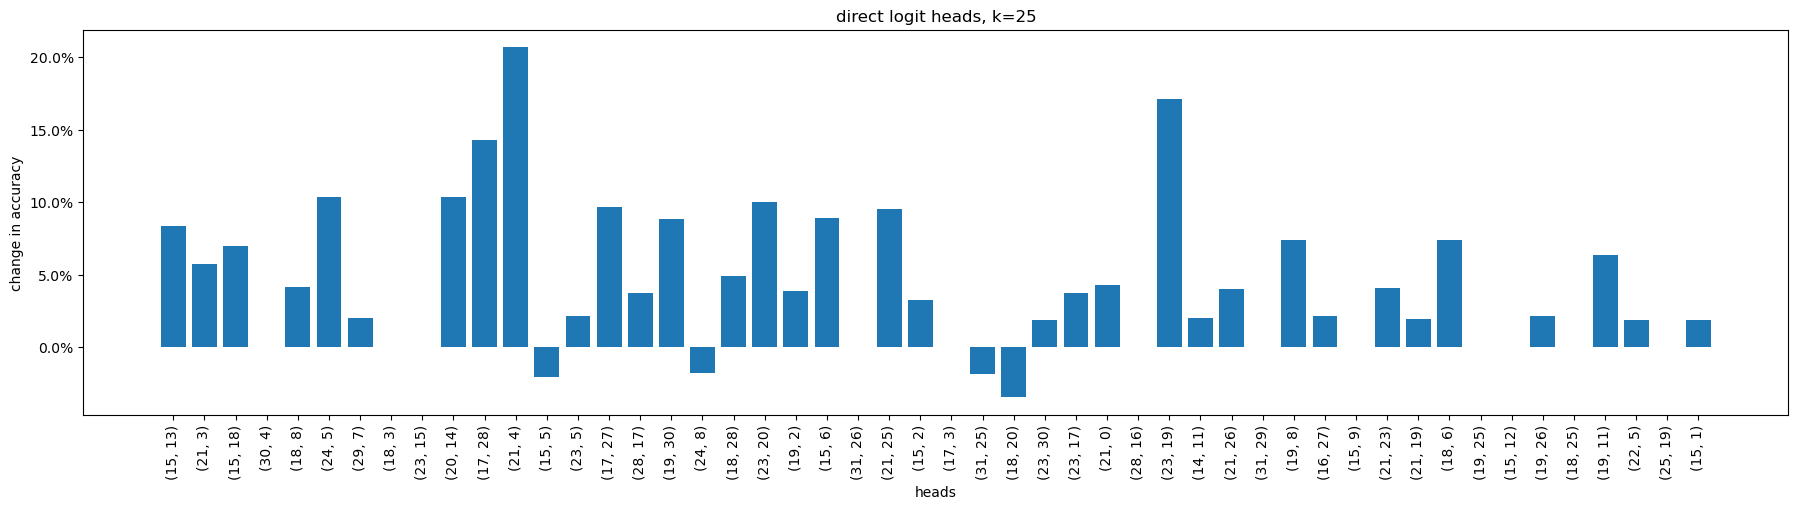

In [32]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_direct_logit_heads_res_k_15.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    new_k = str(k)
    names.append(str((int(new_k.split(".")[2]), int(new_k.split(",")[1][1:-1]))))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(22, 5))
plt.bar(names, scores)
plt.title("direct logit heads, k=25")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

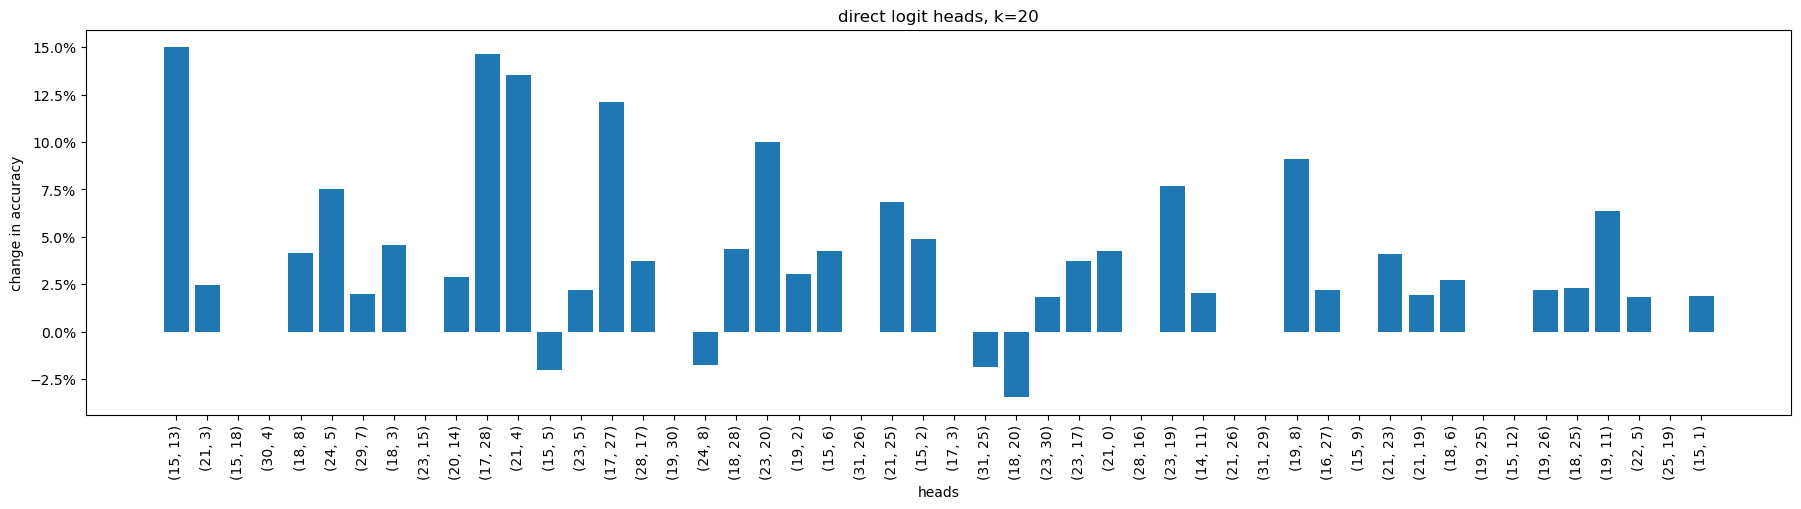

In [123]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_direct_logit_heads_res_k_15.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    new_k = str(k)
    names.append(str((int(new_k.split(".")[2]), int(new_k.split(",")[1][1:-1]))))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(22, 5))
plt.bar(names, scores)
plt.title("direct logit heads, k=20")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

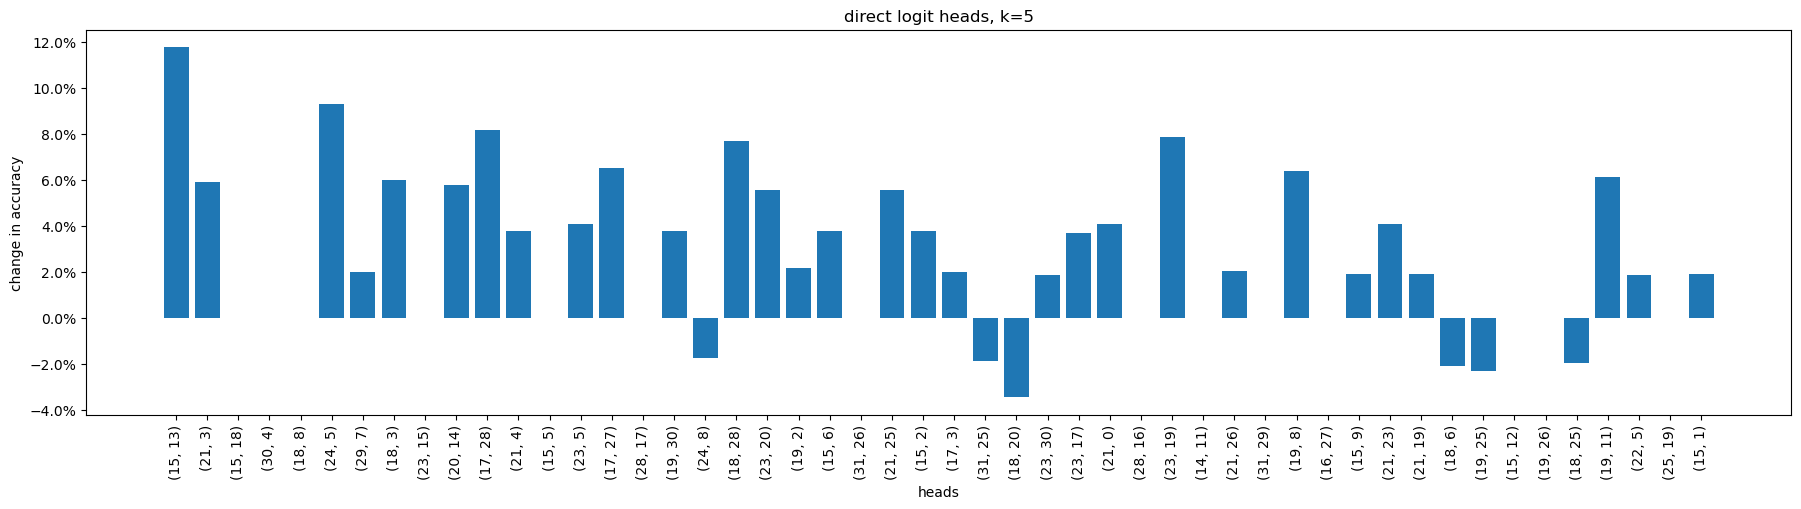

In [22]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_direct_logit_heads_res_k_15.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    new_k = str(k)
    names.append(str((int(new_k.split(".")[2]), int(new_k.split(",")[1][1:-1]))))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(22, 5))
plt.bar(names, scores)
plt.title("direct logit heads, k=5")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

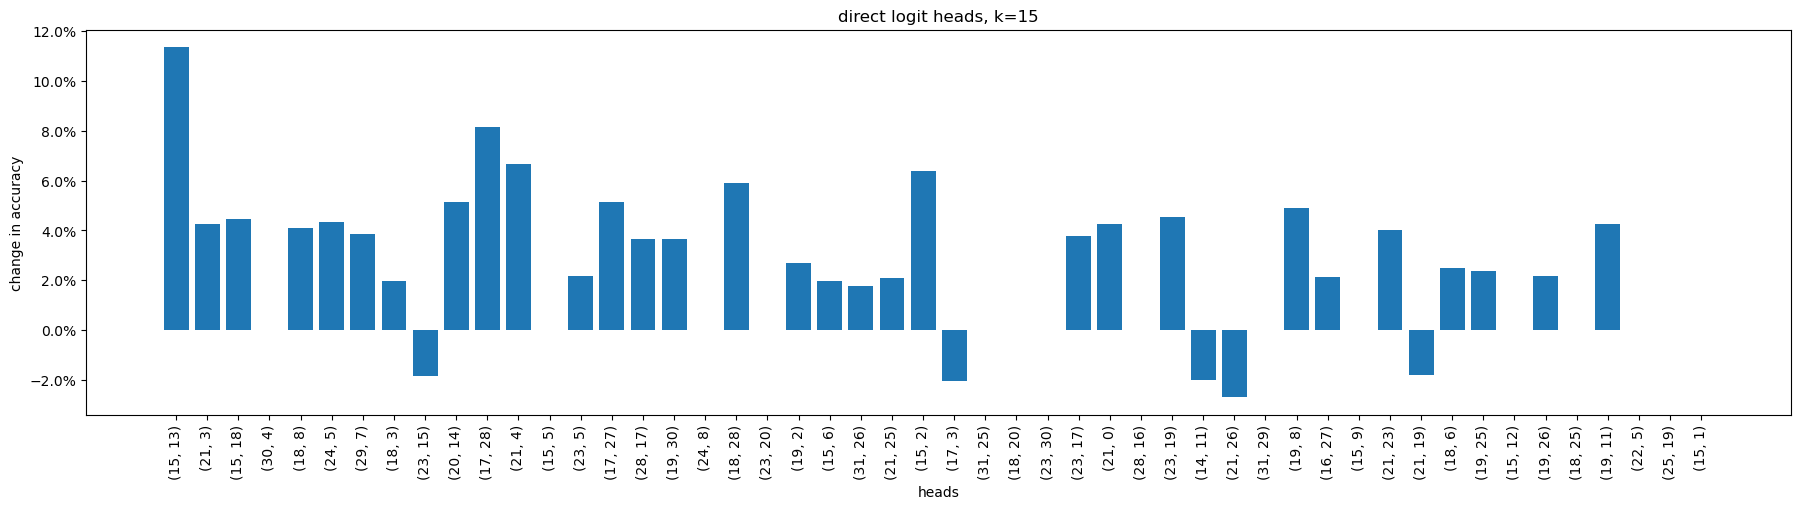

In [54]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_direct_logit_heads_res_k_15.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    new_k = str(k)
    names.append(str((int(new_k.split(".")[2]), int(new_k.split(",")[1][1:-1]))))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(22, 5))
plt.bar(names, scores)
plt.title("direct logit heads, k=15")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

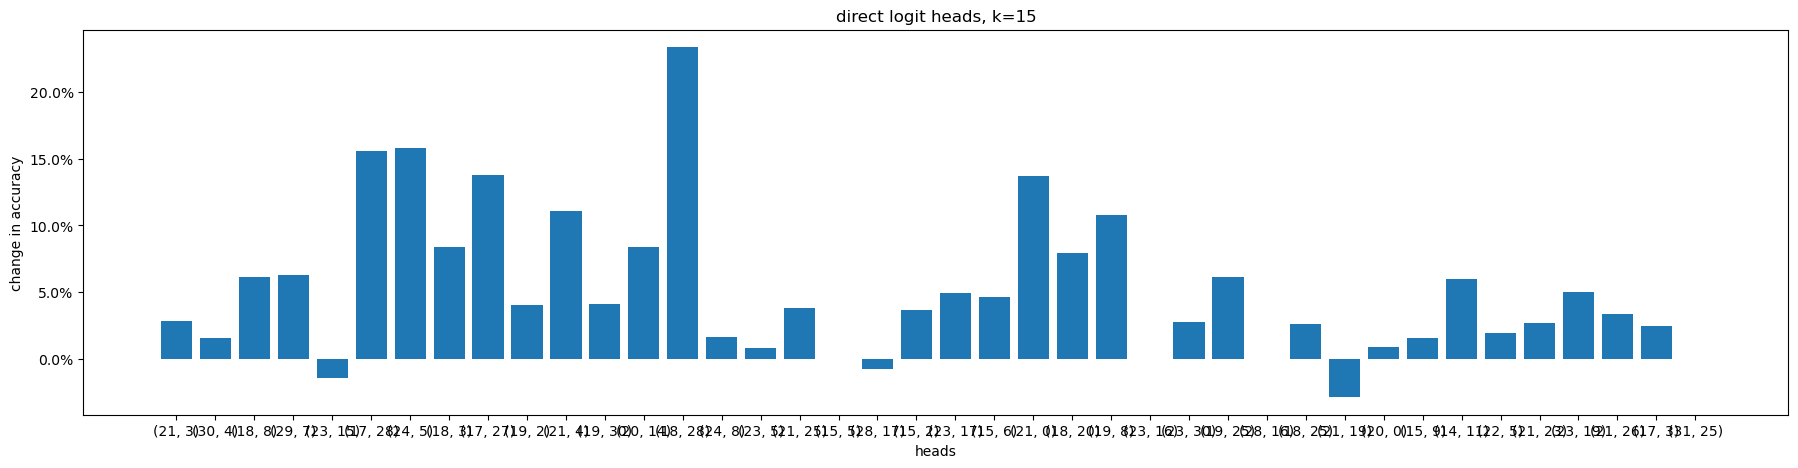

In [56]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

# with open('llama_direct_logit_heads_res_k_15.json', 'r') as f:
#   res = json.load(f)

names = []
scores = []

for k in res:
    names.append(str((int(k.split(".")[2]), int(k.split(",")[1][1:-1]))))
    scores.append((res[k][0] / res[k][1] - 1))

f, ax = plt.subplots(figsize=(22, 5))
plt.bar(names, scores)
plt.title("direct logit heads, k=15")
plt.xlabel("heads")
plt.ylabel("change in accuracy")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

## Remove nodes with low score 


In [28]:
n_value_fetcher = 58
n_pos_trans = 10
n_pos_detect = 25
n_struct_read = 5

In [29]:
with open(
    "../path_patching/minimality_results/direct_logit_heads_15_significance.json", "r"
) as f:
    llama_direct_logit_heads_res_k_15 = json.load(f)

with open(
    "../path_patching/minimality_results/head_at_query_box_token_new_8_significance.json", "r"
) as f:
    llama_head_at_query_box_token_res_k_10 = json.load(f)

with open(
    "../path_patching/minimality_results/heads_affecting_direct_logit_heads_3_significance.json",
    "r",
) as f:
    llama_heads_affecting_direct_logit_heads_res_k_5 = json.load(f)

with open(
    "../path_patching/minimality_results/llama_heads_at_prev_box_pos_2_significance.json", "r"
) as f:
    llama_heads_at_prev_box_pos_k_3 = json.load(f)

In [33]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

root_path = "../path_patching/Sat_Dec__9_15:16:21_2023/path_patching_results/20"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads, _ = analysis_utils.compute_topk_components(
    torch.load(path), k=n_value_fetcher, largest=False
)

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads, _ = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token, _ = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos, _ = analysis_utils.compute_topk_components(
    torch.load(path), k=n_struct_read, largest=False
)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

minimality_threshold = 1 / 100

for k in llama_direct_logit_heads_res_k_15:
    if (
        llama_direct_logit_heads_res_k_15[k][0]
        / llama_direct_logit_heads_res_k_15[k][1]
    ) - 1 < minimality_threshold:
        head = [int(k.split(".")[2]), int(k.split(",")[1][1:-1])]
        direct_logit_heads.remove(head)

for k in llama_head_at_query_box_token_res_k_10:
    if (
        llama_head_at_query_box_token_res_k_10[k][0]
        / llama_head_at_query_box_token_res_k_10[k][1]
    ) - 1 < minimality_threshold:
        head = [int(k.split(".")[2]), int(k.split(",")[1][1:-1])]
        head_at_query_box_token.remove(head)

for k in llama_heads_affecting_direct_logit_heads_res_k_5:
    if (
        llama_heads_affecting_direct_logit_heads_res_k_5[k][0]
        / llama_heads_affecting_direct_logit_heads_res_k_5[k][1]
    ) - 1 < minimality_threshold:
        head = [int(k.split(".")[2]), int(k.split(",")[1][1:-1])]
        heads_affecting_direct_logit_heads.remove(head)

for k in llama_heads_at_prev_box_pos_k_3:
    if (
        llama_heads_at_prev_box_pos_k_3[k][0] / llama_heads_at_prev_box_pos_k_3[k][1]
    ) - 1 < minimality_threshold:
        head = [int(k.split(".")[2]), int(k.split(",")[1][1:-1])]
        heads_at_prev_box_pos.remove(head)

print(f"Direct Logit Heads: {len(direct_logit_heads)}")
print(f"Heads Affecting Direct Logit Heads: {len(heads_affecting_direct_logit_heads)}")
print(f"Heads at Query Box Token: {len(head_at_query_box_token)}")
print(f"Heads at Prev Box Pos: {len(heads_at_prev_box_pos)}")
print(
    f"Total #heads: {len(direct_logit_heads) + len(heads_affecting_direct_logit_heads) + len(head_at_query_box_token) + len(heads_at_prev_box_pos)}"
)

Direct Logit Heads: 40
Heads Affecting Direct Logit Heads: 7
Heads at Query Box Token: 20
Heads at Prev Box Pos: 5
Total #heads: 72


In [34]:
for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)


for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)

In [35]:
eval(model, dataloader, modules, circuit_components, mean_activations)

 20%|██        | 2/10 [00:08<00:32,  4.07s/it]

100%|██████████| 10/10 [00:40<00:00,  4.08s/it]

Task accuracy: 0.66


0.66

In [41]:
circuit_heads = {
    "direct_logit_heads": direct_logit_heads,
    "heads_affecting_direct_logit_heads": heads_affecting_direct_logit_heads,
    "head_at_query_box_token": head_at_query_box_token,
    "heads_at_prev_box_pos": heads_at_prev_box_pos,
}

In [42]:
# Save circuit heads to json file
with open("../new_circuit_heads.json", "w") as outfile:
    json.dump(circuit_heads, outfile)

## Circuit Performance

In [15]:
with open("../new_circuit_heads.json", "r") as file:
    circuit_heads = json.load(file)

In [16]:
direct_logit_heads = circuit_heads["direct_logit_heads"]
heads_affecting_direct_logit_heads = circuit_heads["heads_affecting_direct_logit_heads"]
head_at_query_box_token = circuit_heads["head_at_query_box_token"]
heads_at_prev_box_pos = circuit_heads["heads_at_prev_box_pos"]

print(f"Direct Logit Heads: {len(direct_logit_heads)}")
print(f"Heads Affecting Direct Logit Heads: {len(heads_affecting_direct_logit_heads)}")
print(f"Heads at Query Box Token: {len(head_at_query_box_token)}")
print(f"Heads at Prev Box Pos: {len(heads_at_prev_box_pos)}")
print(
    f"Total #heads: {len(direct_logit_heads) + len(heads_affecting_direct_logit_heads) + len(head_at_query_box_token) + len(heads_at_prev_box_pos)}"
)

Direct Logit Heads: 40
Heads Affecting Direct Logit Heads: 7
Heads at Query Box Token: 20
Heads at Prev Box Pos: 5
Total #heads: 72


In [17]:
circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)


for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)

In [18]:
eval(model, dataloader, modules, circuit_components, mean_activations)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:41<00:00,  4.18s/it]

Task accuracy: 0.66


0.66

## Computing performance of initial circuits

In [18]:
# Find all directories in the root directory
root_dir = "/home/local_nikhil/Projects/Anima-2.0/path_patching/Sat_Dec_23_14:13:13_2023/goat_pp_results"
# root_dir = "/home/local_nikhil/Projects/Anima-2.0/path_patching/Mon_Dec__4_04:16:04_2023/path_patching_results"
dirs = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
dirs = [os.path.join(root_dir, d) for d in dirs]

In [44]:
n_value_fetcher = 101
n_pos_trans = 30
n_pos_detect = 50
n_struct_read = 40

In [45]:
for subdir in dirs:
    if "/82" not in subdir:
        continue
    print(subdir)
    circuit_components = {}
    circuit_components[0] = defaultdict(list)
    circuit_components[2] = defaultdict(list)
    circuit_components[-1] = defaultdict(list)

    root_path = subdir
    path = root_path + "/value_fetcher.pt"
    logit_values = torch.load(path)
    direct_logit_heads, _ = analysis_utils.compute_topk_components(
        torch.load(path), k=n_value_fetcher, largest=False
    )

    path = root_path + "/pos_transmitter.pt"
    logit_values = torch.load(path)
    heads_affecting_direct_logit_heads, _ = analysis_utils.compute_topk_components(
        torch.load(path), k=n_pos_trans, largest=False
    )

    path = root_path + "/pos_detector.pt"
    logit_values = torch.load(path)
    head_at_query_box_token, _ = analysis_utils.compute_topk_components(
        torch.load(path), k=n_pos_detect, largest=False
    )

    path = root_path + "/struct_reader.pt"
    logit_values = torch.load(path)
    heads_at_prev_box_pos, _ = analysis_utils.compute_topk_components(
        torch.load(path), k=n_struct_read, largest=False
    )

    intersection = []
    for head in direct_logit_heads:
        if head in heads_affecting_direct_logit_heads:
            intersection.append(head)

    for head in intersection:
        direct_logit_heads.remove(head)

    print(
        len(direct_logit_heads),
        len(heads_affecting_direct_logit_heads),
        len(head_at_query_box_token),
        len(heads_at_prev_box_pos),
    )

    for layer_idx, head in direct_logit_heads:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[0][layer].append(head)

    for layer_idx, head in heads_affecting_direct_logit_heads:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[0][layer].append(head)

    for layer_idx, head in head_at_query_box_token:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[2][layer].append(head)

    for layer_idx, head in heads_at_prev_box_pos:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[-1][layer].append(head)

    for pos in circuit_components.keys():
        for layer_idx in circuit_components[pos].keys():
            circuit_components[pos][layer_idx] = list(
                set(circuit_components[pos][layer_idx])
            )

    eval(model, dataloader, modules, circuit_components, mean_activations)

/home/local_nikhil/Projects/Anima-2.0/path_patching/Sat_Dec_23_14:13:13_2023/goat_pp_results/82
80 30 50 40


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:42<00:00,  4.27s/it]

Task accuracy: 0.81
